## Projeto Previsão dados de TRP - incluindo 1o semestre de 2019 no TRAIN

- Usando o modelo PROPHET (facebook)
    - https://facebook.github.io/prophet/
    - https://www.youtube.com/watch?v=95-HMzxsghY
    - https://towardsdatascience.com/a-quick-start-of-time-series-forecasting-with-a-practical-example-using-fb-prophet-31c4447a2274
    - https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/
    - https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3


- Estabelecer sazonalidade de TRP por mês e dia de semana
- <font color='green'>Fonte: dados diários de audiência do MW - modelo se adapta melhor com a maior frequência de dados<font color='black'>
- Olhar como inserir os feriados nacionais <font color='red'>upper and lower window = 1/-1<font color='black'>


- Usando dados:
    - Emissora: GLOBO
    - df separado por Daypart:
        - df_1 -- 06:00:00 - 11:59:00
        - df_2 -- 12:00:00 - 17:59:00
        - df_3 -- 18:00:00 - 23:59:00
        - df_4 -- 24:00:00 - 29:59:00
        - Dados de treino: <font color='red'>jan/2001 a jun/2019<font color='black'>
        - Dados de teste: <font color='red'>jul/2019 a set/2019<font color='black'>
    - Praça: NACIONAL
    - Target: AS ABC 18-49
    - Datas: jan/2001 a set2019

In [3]:
import numpy as np
import datetime

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.2f}'.format

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

In [4]:
#using PROPHET
from fbprophet import Prophet

In [9]:
## Abrindo Arquivo
df_all = pd.read_csv('Dados/GLOBO_Daypart_2001a2019.csv', decimal=',', sep=';', skipfooter=3, encoding='UTF-8-sig',
                        header=None)

In [10]:
## Renomeando as colunas
df_all.columns = ['emissora', 'data', 'daypart', 'Rat#_AS ABC 18-49', 'Rat%_AS ABC 18-49']

In [11]:
## Eliminando dados vazios
df_all.dropna(inplace = True)

In [12]:
df_all.tail(10)

emissora        data              daypart  Rat#_AS ABC 18-49  \
28795    Globo  13/09/2019  24:00:00 - 29:59:00             525.96   
28796    Globo  14/09/2019  06:00:00 - 11:59:00             656.28   
28797    Globo  14/09/2019  12:00:00 - 17:59:00            1358.58   
28798    Globo  14/09/2019  18:00:00 - 23:59:00            2268.89   
28799    Globo  14/09/2019  24:00:00 - 29:59:00             658.23   
28800    Globo  15/09/2019  06:00:00 - 11:59:00             932.58   
28801    Globo  15/09/2019  12:00:00 - 17:59:00            1924.79   
28802    Globo  15/09/2019  18:00:00 - 23:59:00            1817.89   
28803    Globo  15/09/2019  24:00:00 - 29:59:00             598.01   
28804    Globo  16/09/2019  06:00:00 - 11:59:00             859.13   

       Rat%_AS ABC 18-49  
28795               1.78  
28796               2.22  
28797               4.60  
28798               7.69  
28799               2.23  
28800               3.16  
28801               6.52  
28802               6.15  
28803               2.02  
28804               2.90

In [13]:
## Transformando valores de data no formato de data
df_all['data'] = pd.to_datetime(df_all['data'], format='%d/%m/%Y')

#Separar uma coluna para ano
df_all['ano'] = pd.DatetimeIndex(df_all['data']).year

In [14]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27240 entries, 0 to 28804
Data columns (total 6 columns):
emissora             27240 non-null object
data                 27240 non-null datetime64[ns]
daypart              27240 non-null object
Rat#_AS ABC 18-49    27240 non-null float64
Rat%_AS ABC 18-49    27240 non-null float64
ano                  27240 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.5+ MB


In [15]:
df_all.describe()

Rat#_AS ABC 18-49  Rat%_AS ABC 18-49      ano
count           27240.00           27240.00 27240.00
mean             1487.56               5.96  2009.86
std               991.93               4.16     5.40
min                47.93               0.23  2001.00
25%               657.94               2.60  2005.00
50%              1155.28               4.63  2010.00
75%              2114.82               8.30  2015.00
max              5710.25              25.20  2019.00

In [16]:
df_all['daypart'].value_counts()

06:00:00 - 11:59:00    6834
12:00:00 - 17:59:00    6833
18:00:00 - 23:59:00    6832
24:00:00 - 29:59:00    6741
Name: daypart, dtype: int64

In [18]:
#Existem dados ausentes em alguns Daypart
df_all.groupby(['ano', 'daypart']).count()

emissora  data  Rat#_AS ABC 18-49  Rat%_AS ABC 18-49
ano  daypart                                                                  
2001 06:00:00 - 11:59:00       365   365                365                365
     12:00:00 - 17:59:00       365   365                365                365
     18:00:00 - 23:59:00       365   365                365                365
     24:00:00 - 29:59:00       354   354                354                354
2002 06:00:00 - 11:59:00       365   365                365                365
     12:00:00 - 17:59:00       365   365                365                365
     18:00:00 - 23:59:00       365   365                365                365
     24:00:00 - 29:59:00       354   354                354                354
2003 06:00:00 - 11:59:00       365   365                365                365
     12:00:00 - 17:59:00       365   365                365                365
     18:00:00 - 23:59:00       365   365                365                365
     24:00:00 - 29:59:00       361   361                361                361
2004 06:00:00 - 11:59:00       366   366                366                366
     12:00:00 - 17:59:00       366   366                366                366
     18:00:00 - 23:59:00       366   366                366                366
     24:00:00 - 29:59:00       360   360                360                360
2005 06:00:00 - 11:59:00       365   365                365                365
     12:00:00 - 17:59:00       365   365                365                365
     18:00:00 - 23:59:00       365   365                365                365
     24:00:00 - 29:59:00       360   360                360                360
2006 06:00:00 - 11:59:00       365   365                365                365
     12:00:00 - 17:59:00       365   365                365                365
     18:00:00 - 23:59:00       365   365                365                365
     24:00:00 - 29:59:00       361   361                361                361
2007 06:00:00 - 11:59:00       365   365                365                365
     12:00:00 - 17:59:00       365   365                365                365
     18:00:00 - 23:59:00       365   365                365                365
     24:00:00 - 29:59:00       362   362                362                362
2008 06:00:00 - 11:59:00       366   366                366                366
     12:00:00 - 17:59:00       366   366                366                366
     18:00:00 - 23:59:00       366   366                366                366
     24:00:00 - 29:59:00       363   363                363                363
2009 06:00:00 - 11:59:00       365   365                365                365
     12:00:00 - 17:59:00       365   365                365                365
     18:00:00 - 23:59:00       365   365                365                365
     24:00:00 - 29:59:00       360   360                360                360
2010 06:00:00 - 11:59:00       365   365                365                365
     12:00:00 - 17:59:00       365   365                365                365
     18:00:00 - 23:59:00       365   365                365                365
     24:00:00 - 29:59:00       363   363                363                363
2011 06:00:00 - 11:59:00       365   365                365                365
     12:00:00 - 17:59:00       365   365                365                365
     18:00:00 - 23:59:00       365   365                365                365
     24:00:00 - 29:59:00       361   361                361                361
2012 06:00:00 - 11:59:00       366   366                366                366
     12:00:00 - 17:59:00       366   366                366                366
     18:00:00 - 23:59:00       366   366                366                366
     24:00:00 - 29:59:00       362   362                362                362
2013 06:00:00 - 11:59:00       365   365                365                3

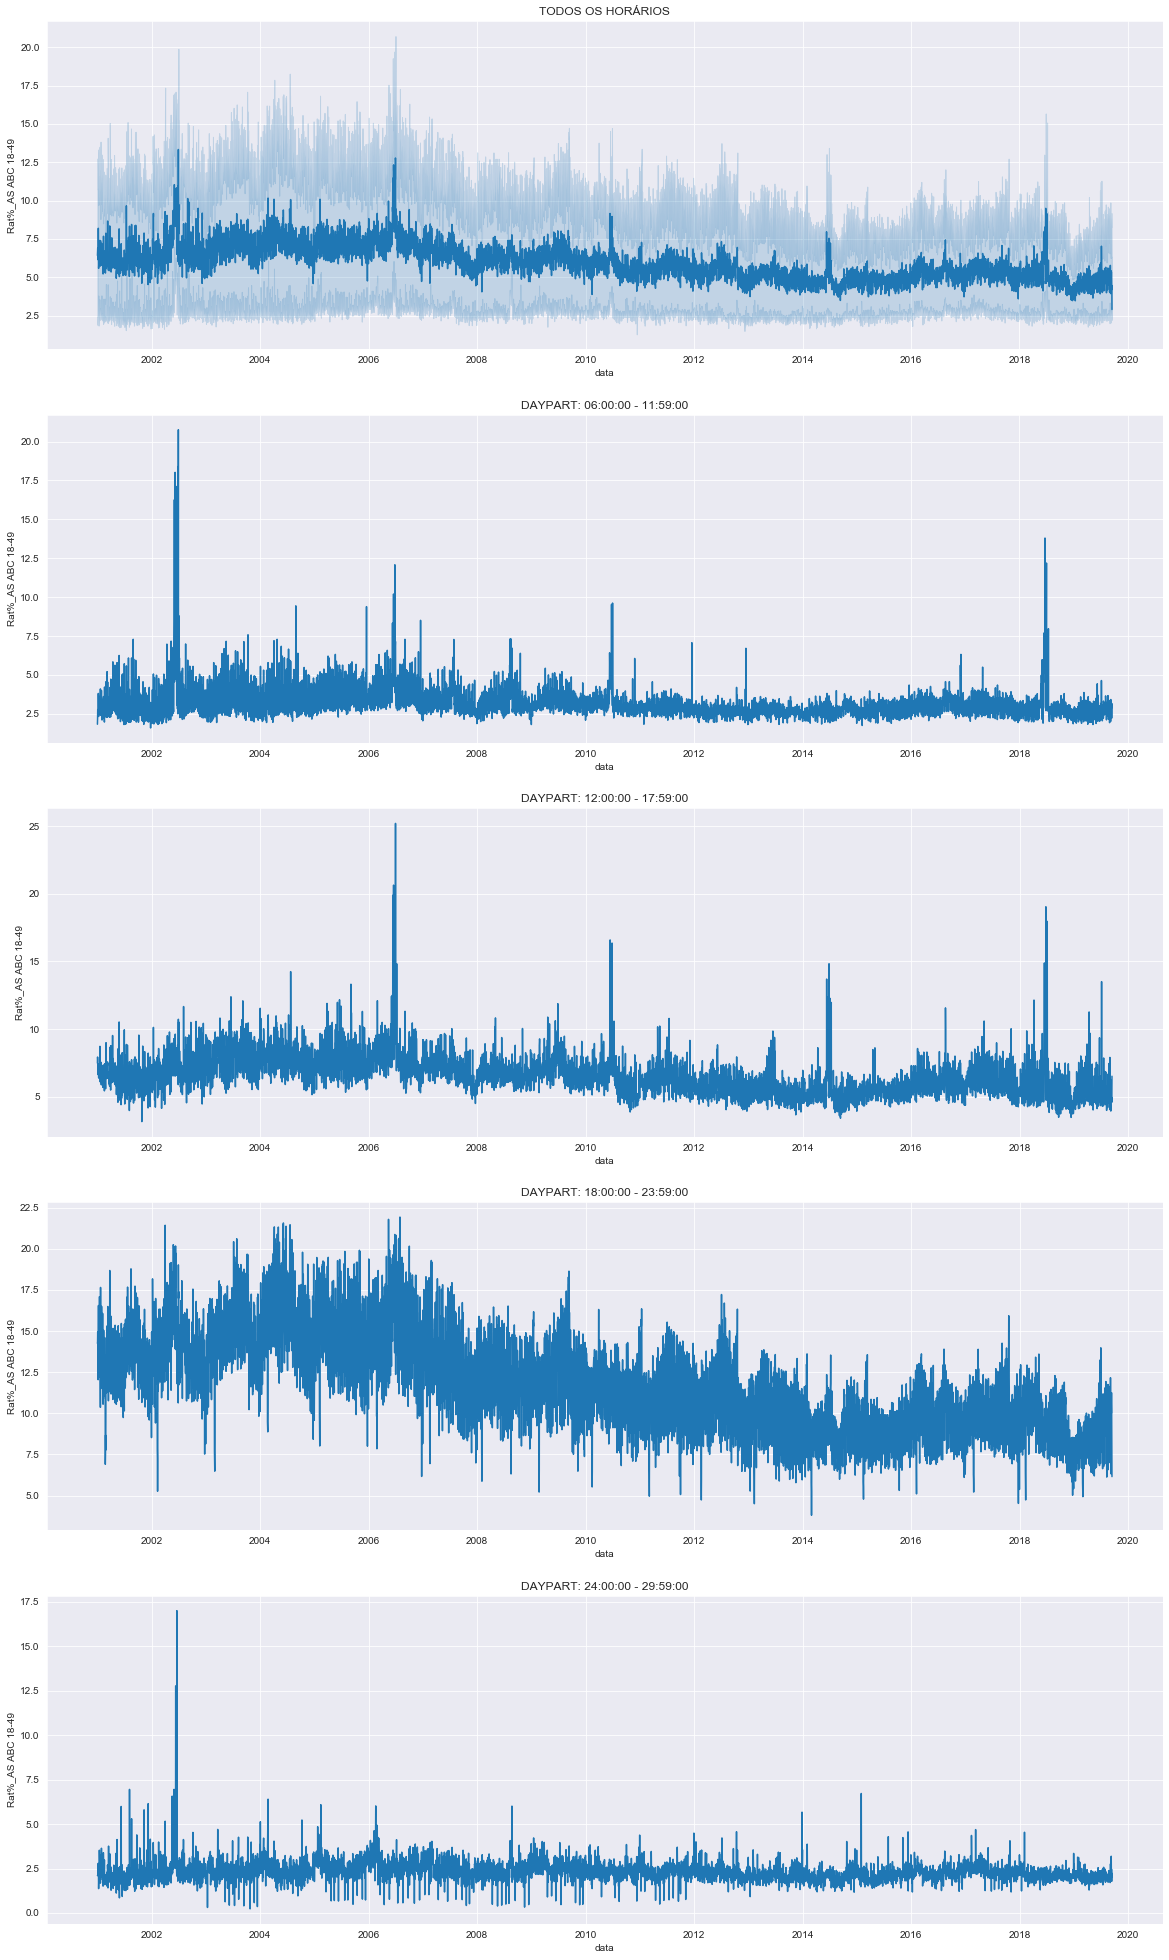

In [19]:
#exploração dos dados
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5,1,figsize=(20,35))

#Todos os Daypart
sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data=df_all, ax=ax1)
ax1.set_title('TODOS OS HORÁRIOS')

#Somente DAYPART: 06:00:00 - 11:59:00
sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data=df_all.loc[df_all['daypart'] == '06:00:00 - 11:59:00'], ax=ax2)
ax2.set_title('DAYPART: 06:00:00 - 11:59:00')

#Somente DAYPART: 12:00:00 - 17:59:00
sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data=df_all.loc[df_all['daypart'] == '12:00:00 - 17:59:00'], ax=ax3)
ax3.set_title('DAYPART: 12:00:00 - 17:59:00')

#Somente DAYPART: 18:00:00 - 23:59:00
sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data=df_all.loc[df_all['daypart'] == '18:00:00 - 23:59:00'], ax=ax4)
ax4.set_title('DAYPART: 18:00:00 - 23:59:00')

#Somente DAYPART: 24:00:00 - 29:59:00
sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data=df_all.loc[df_all['daypart'] == '24:00:00 - 29:59:00'], ax=ax5)
ax5.set_title('DAYPART: 24:00:00 - 29:59:00');

### Exemplo de Outliers
- motivo: Copa do Mundo
- dependendo da sede interfere nos dados de diferentes daypart

- Os outliers de 2002, 2006, 2010, 2014, 2018 são referentes a copa do mundo
    - depende do país sede para saber qual o daypart que o evento interfere
    - OPÇÃO: eliminar esses valores para não atrapalhar a análise? Caso contrário vai tendenciar a curva a aumentar nesses anos
    - REALIZADO: Foi feita a previsão com esses outliers e avaliada a qualidade do modelo para os dados disponíveis

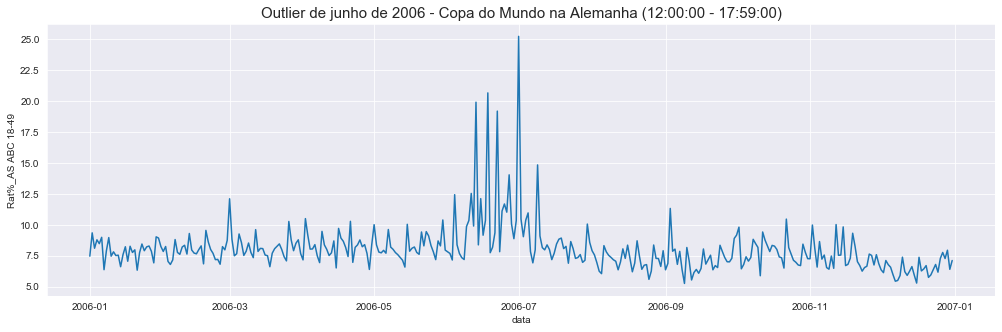

In [20]:
fig, ax1 = plt.subplots(figsize=(17,5))
sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data=df_all.loc[(df_all['ano'] == 2006) &
                                                                  (df_all['daypart'] == '12:00:00 - 17:59:00')], ax=ax1)
ax1.set_title('Outlier de junho de 2006 - Copa do Mundo na Alemanha (12:00:00 - 17:59:00)', size=15);

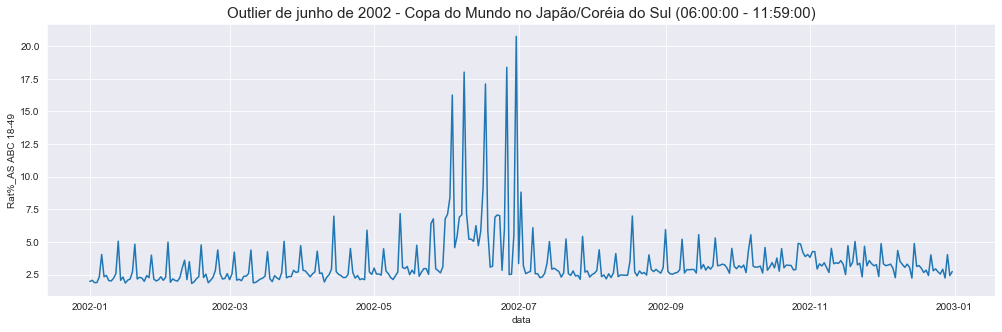

In [21]:
fig, ax1 = plt.subplots(figsize=(17,5))
sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data=df_all.loc[(df_all['ano'] == 2002) &
                                                                  (df_all['daypart'] == '06:00:00 - 11:59:00')], ax=ax1)
ax1.set_title('Outlier de junho de 2002 - Copa do Mundo no Japão/Coréia do Sul (06:00:00 - 11:59:00)', size=15);

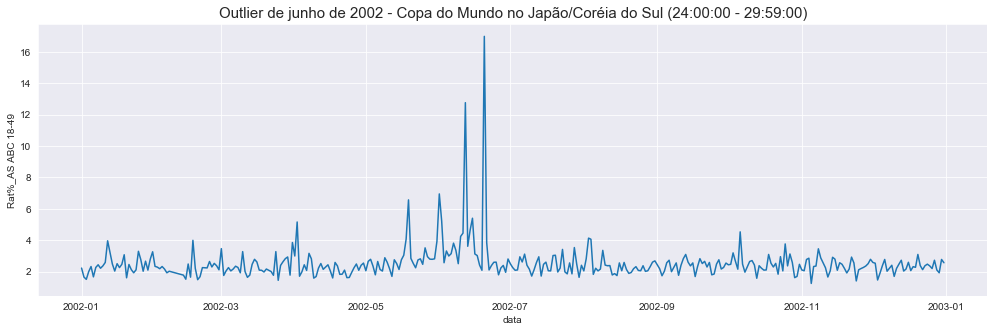

In [22]:
fig, ax1 = plt.subplots(figsize=(17,5))
sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data=df_all.loc[(df_all['ano'] == 2002) &
                                                                  (df_all['daypart'] == '24:00:00 - 29:59:00')], ax=ax1)
ax1.set_title('Outlier de junho de 2002 - Copa do Mundo no Japão/Coréia do Sul (24:00:00 - 29:59:00)', size=15);

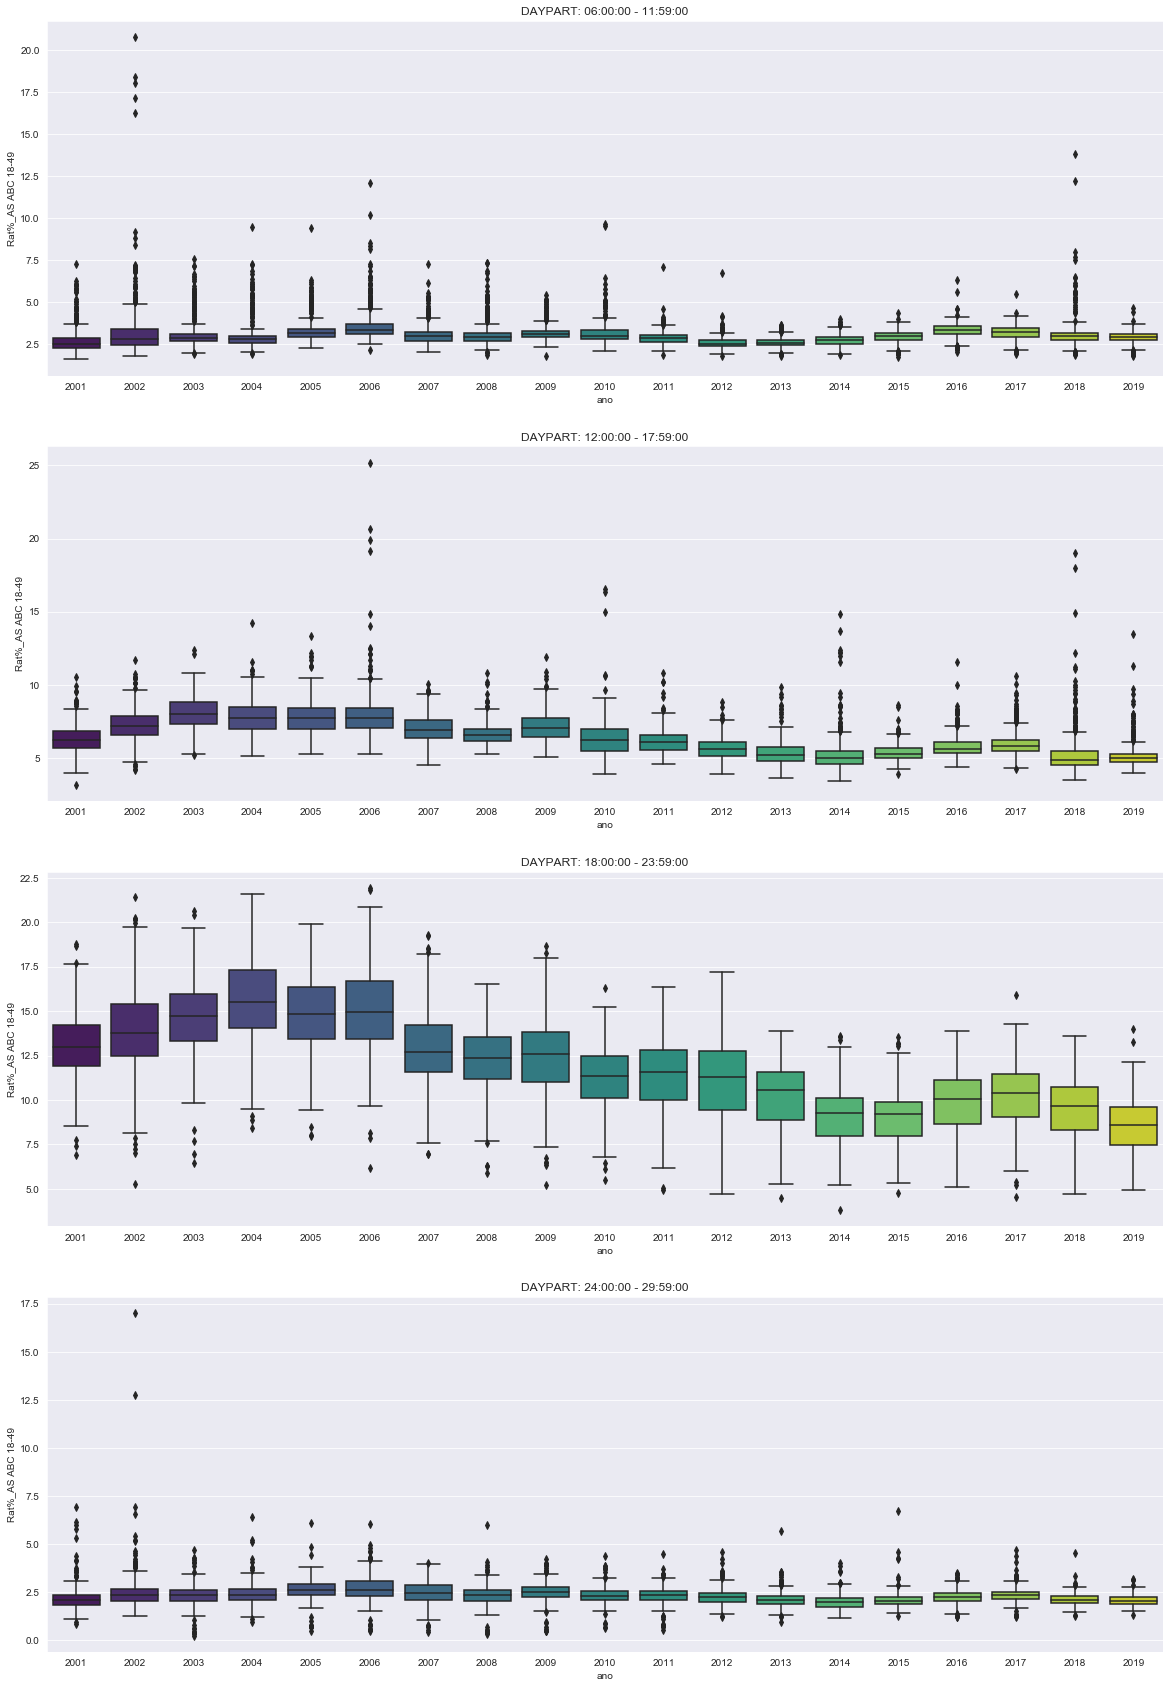

In [23]:
#Boxplot de cada Daypart por ano
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(20,30), sharey = False)

#Somente DAYPART: 06:00:00 - 11:59:00
sns.boxplot(x = 'ano', y = 'Rat%_AS ABC 18-49', data = df_all.loc[df_all['daypart']=='06:00:00 - 11:59:00'],
            palette='viridis', ax=ax1)
ax1.set_title('DAYPART: 06:00:00 - 11:59:00')

#Somente DAYPART: 12:00:00 - 17:59:00
sns.boxplot(x = 'ano', y = 'Rat%_AS ABC 18-49', data = df_all.loc[df_all['daypart']=='12:00:00 - 17:59:00'],
            palette='viridis', ax=ax2)
ax2.set_title('DAYPART: 12:00:00 - 17:59:00')

#Somente DAYPART: 18:00:00 - 23:59:00
sns.boxplot(x = 'ano', y = 'Rat%_AS ABC 18-49', data = df_all.loc[df_all['daypart']=='18:00:00 - 23:59:00'],
            palette='viridis', ax=ax3)
ax3.set_title('DAYPART: 18:00:00 - 23:59:00')

#Somente DAYPART: 24:00:00 - 29:59:00
sns.boxplot(x = 'ano', y = 'Rat%_AS ABC 18-49', data = df_all.loc[df_all['daypart']=='24:00:00 - 29:59:00'],
            palette='viridis', ax=ax4)
ax4.set_title('DAYPART: 24:00:00 - 29:59:00');

#### Outliers:
- As maiores variações de TRP acontecem no período da noite (18:00:00 - 23:59:00)


- 06:00:00 - 11:59:00 -- > 5,00
- 12:00:00 - 17:59:00 -- > 10,00
- 18:00:00 - 23:59:00 -- > 20,00
- 24:00:00 - 29:59:00 -- > 3,00

## Teste do PROPHET - por daypart sem correção
- DF:
    - df_1 -- 06:00:00 - 11:59:00
    - df_2 -- 12:00:00 - 17:59:00
    - df_3 -- 18:00:00 - 23:59:00
    - df_4 -- 24:00:00 - 29:59:00
- <font color='red'>Dados de treino: jan/2001 a jun/2019
- Dados de teste: jul/2019 a set/2019

In [24]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27240 entries, 0 to 28804
Data columns (total 6 columns):
emissora             27240 non-null object
data                 27240 non-null datetime64[ns]
daypart              27240 non-null object
Rat#_AS ABC 18-49    27240 non-null float64
Rat%_AS ABC 18-49    27240 non-null float64
ano                  27240 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.5+ MB


In [25]:
#inserindo carnaval como feriado
holidays = pd.DataFrame({'holiday': 'carnaval', 'ds': pd.to_datetime(['2001-02-26', '2001-02-27', '2001-02-28',
                                                                      '2002-02-11', '2002-02-12', '2002-02-13',
                                                                      '2003-03-03', '2003-03-04', '2003-03-05',
                                                                      '2004-02-23', '2004-02-24', '2004-02-25',
                                                                      '2005-02-07', '2005-02-08', '2005-02-09',
                                                                      '2006-02-27', '2006-02-28', '2006-03-01',
                                                                      '2007-02-19', '2007-02-20', '2007-02-21',
                                                                      '2008-02-04', '2008-02-05', '2008-02-06',
                                                                      '2009-02-23', '2009-02-24', '2009-02-25',
                                                                      '2010-02-15', '2010-02-16', '2010-02-17',
                                                                      '2011-03-07', '2011-03-08', '2011-03-09',
                                                                      '2012-02-20', '2012-02-21', '2012-02-22',                                                                      
                                                                      '2013-02-11', '2013-02-12', '2013-02-13',
                                                                      '2014-03-03', '2014-03-04', '2014-03-05',
                                                                      '2015-02-16', '2015-02-17', '2015-02-18',
                                                                      '2016-02-08', '2016-02-09', '2016-02-10',
                                                                      '2017-02-27', '2017-02-28', '2017-03-01',
                                                                      '2018-02-12', '2018-02-13', '2018-02-14',
                                                                      '2019-03-04', '2019-03-05', '2019-03-06',
                                                                      '2020-02-24', '2020-02-25', '2020-02-26'
                                                                     ]),
                         'lower_window': -1,
                         'upper_window': 1})

In [56]:
m1.train_holiday_names

0                      carnaval
1                New Year's Day
2                    Tiradentes
3                  Worker's Day
4              Independence Day
5    Our Lady of the Apparition
6                All Souls' Day
7     Republic Proclamation Day
8                     Christmas
dtype: object

### df_1 - 06:00:00 - 11:59:00 (MANHÃ)

### TREINO

In [30]:
# Separando a base para TREINO - jan/2001 a jun/2019
df_1 = df_all.loc[(df_all['daypart'] == '06:00:00 - 11:59:00') &
                  (df_all['data'] < '2019-07-01')]
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6755 entries, 0 to 28480
Data columns (total 6 columns):
emissora             6755 non-null object
data                 6755 non-null datetime64[ns]
daypart              6755 non-null object
Rat#_AS ABC 18-49    6755 non-null float64
Rat%_AS ABC 18-49    6755 non-null float64
ano                  6755 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 369.4+ KB


In [31]:
df_1.tail()

emissora       data              daypart  Rat#_AS ABC 18-49  \
28462    Globo 2019-06-26  06:00:00 - 11:59:00             777.45   
28466    Globo 2019-06-27  06:00:00 - 11:59:00             884.30   
28471    Globo 2019-06-28  06:00:00 - 11:59:00             817.41   
28475    Globo 2019-06-29  06:00:00 - 11:59:00             604.77   
28480    Globo 2019-06-30  06:00:00 - 11:59:00             860.57   

       Rat%_AS ABC 18-49   ano  
28462               2.63  2019  
28466               2.99  2019  
28471               2.77  2019  
28475               2.05  2019  
28480               2.92  2019

In [54]:
## Formatar a base para o modelo de entrada do Prophet:
# 1a coluna "ds" para os valores de data | 2a coluna "y" para a variável de medida (TRP)
df_1aj = df_1[['data', 'Rat%_AS ABC 18-49']]
df_1aj.columns = ['ds', 'y']

### TESTE

In [32]:
# Separando a base para TESTE - jul/2019 a set/2019
df_1_2019 = df_all.loc[(df_all['daypart'] == '06:00:00 - 11:59:00') &
                  (df_all['data'] >= '2019-07-01')]
df_1_2019.drop(['emissora', 'daypart', 'Rat#_AS ABC 18-49', 'ano'], axis=1, inplace=True)

In [33]:
## Formatar a base para o modelo de entrada do Prophet:
# 1a coluna "ds" para os valores de data | 2a coluna "y" para a variável de medida (TRP)

df_1_2019.columns = ['ds', 'y']

In [34]:
df_1_2019.info()
print(df_1_2019.head(3))
df_1_2019.tail(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 28484 to 28804
Data columns (total 2 columns):
ds    79 non-null datetime64[ns]
y     79 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 KB
              ds    y
28484 2019-07-01 2.85
28488 2019-07-02 2.92
28492 2019-07-03 2.77


ds    y
28796 2019-09-14 2.22
28800 2019-09-15 3.16
28804 2019-09-16 2.90

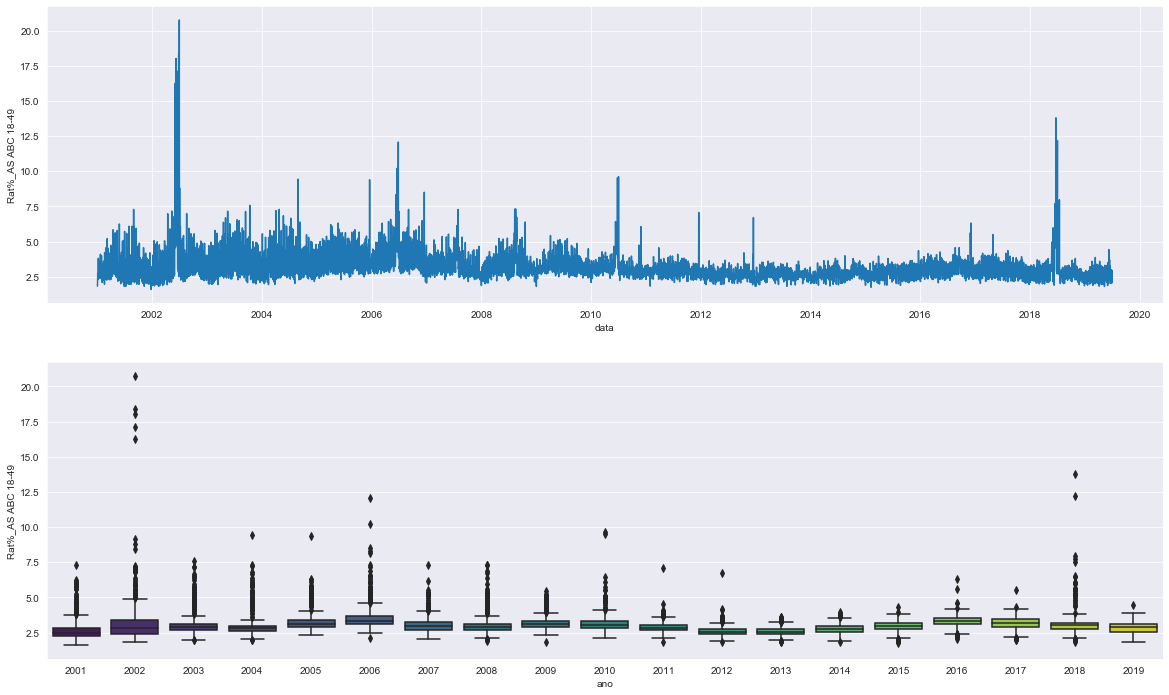

In [35]:
#Vizualização dos dados de TREINO
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,12), sharey = False)

sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data = df_1, ax=ax1)
sns.boxplot(x = 'ano', y = 'Rat%_AS ABC 18-49', data = df_1, palette='viridis', ax=ax2);

### df_2 - 12:00:00 - 17:59:00 (TARDE)

### TREINO

In [36]:
# Separando a base para TREINO - jan/2001 a jun/2019
df_2 = df_all.loc[(df_all['daypart'] == '12:00:00 - 17:59:00') &
                  (df_all['data'] < '2019-07-01')]
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6755 entries, 1 to 28481
Data columns (total 6 columns):
emissora             6755 non-null object
data                 6755 non-null datetime64[ns]
daypart              6755 non-null object
Rat#_AS ABC 18-49    6755 non-null float64
Rat%_AS ABC 18-49    6755 non-null float64
ano                  6755 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 369.4+ KB


In [37]:
df_2.tail()

emissora       data              daypart  Rat#_AS ABC 18-49  \
28463    Globo 2019-06-26  12:00:00 - 17:59:00            1481.74   
28467    Globo 2019-06-27  12:00:00 - 17:59:00            1452.31   
28472    Globo 2019-06-28  12:00:00 - 17:59:00            1474.42   
28476    Globo 2019-06-29  12:00:00 - 17:59:00            1284.43   
28481    Globo 2019-06-30  12:00:00 - 17:59:00            1925.39   

       Rat%_AS ABC 18-49   ano  
28463               5.01  2019  
28467               4.92  2019  
28472               4.99  2019  
28476               4.35  2019  
28481               6.52  2019

In [123]:
## Formatar a base para o modelo de entrada do Prophet:
# 1a coluna "ds" para os valores de data | 2a coluna "y" para a variável de medida (TRP)
df_2aj = df_2[['data', 'Rat%_AS ABC 18-49']]
df_2aj.columns = ['ds', 'y']

### TESTE

In [38]:
# Separando a base para TESTE - jul/2019 a set/2019
df_2_2019 = df_all.loc[(df_all['daypart'] == '12:00:00 - 17:59:00') &
                  (df_all['data'] >= '2019-07-01')]
df_2_2019.drop(['emissora', 'daypart', 'Rat#_AS ABC 18-49', 'ano'], axis=1, inplace=True)

## Formatar a base para o modelo de entrada do Prophet:
# 1a coluna "ds" para os valores de data | 2a coluna "y" para a variável de medida (TRP)
df_2_2019.columns = ['ds', 'y']

In [39]:
df_2_2019.info()
print(df_2_2019.tail(3))
df_2_2019.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 28485 to 28801
Data columns (total 2 columns):
ds    78 non-null datetime64[ns]
y     78 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB
              ds    y
28793 2019-09-13 4.96
28797 2019-09-14 4.60
28801 2019-09-15 6.52


ds    y
28485 2019-07-01 5.18
28489 2019-07-02 4.88
28493 2019-07-03 5.00

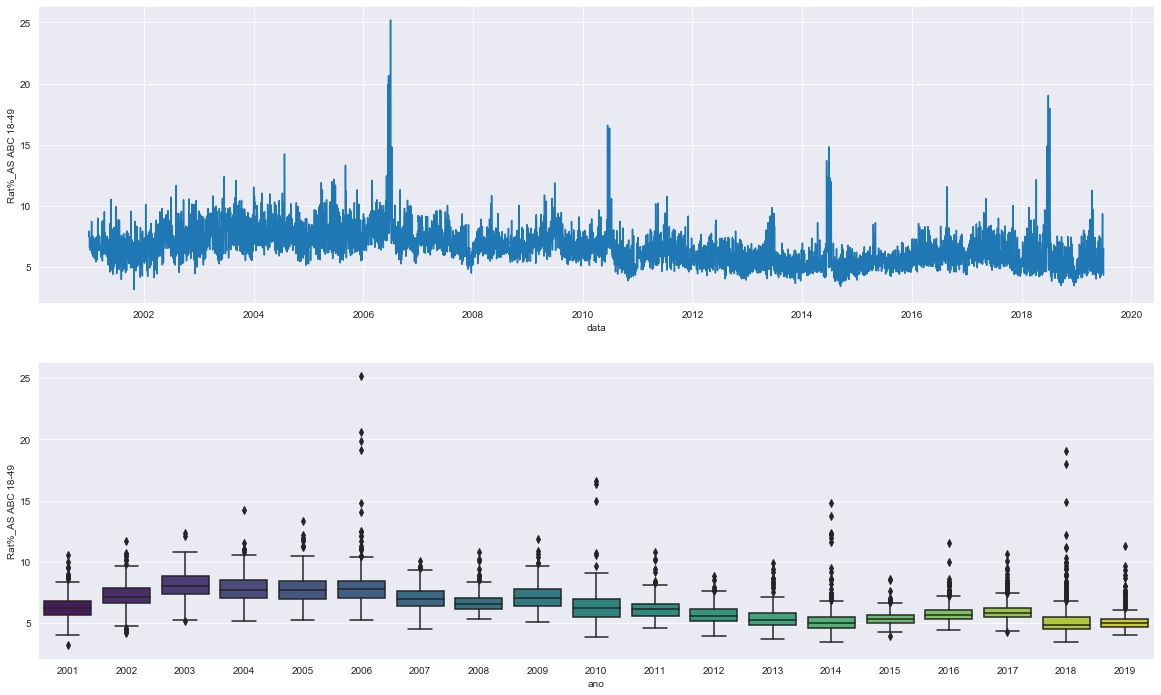

In [40]:
#Vizualização dos dados - TREINO
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,12), sharey = False)

sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data = df_2, ax=ax1)
sns.boxplot(x = 'ano', y = 'Rat%_AS ABC 18-49', data = df_2, palette='viridis', ax=ax2);

### df_3 - 18:00:00 - 23:59:00 (NOITE)

### TREINO

In [44]:
# Separando a base para TREINO - jan/2001 a jun/2019
df_3 = df_all.loc[(df_all['daypart'] == '18:00:00 - 23:59:00') &
                  (df_all['data'] < '2019-07-01')]
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6754 entries, 2 to 28482
Data columns (total 6 columns):
emissora             6754 non-null object
data                 6754 non-null datetime64[ns]
daypart              6754 non-null object
Rat#_AS ABC 18-49    6754 non-null float64
Rat%_AS ABC 18-49    6754 non-null float64
ano                  6754 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 369.4+ KB


In [45]:
df_3.tail()

emissora       data              daypart  Rat#_AS ABC 18-49  \
28464    Globo 2019-06-26  18:00:00 - 23:59:00            2816.91   
28468    Globo 2019-06-27  18:00:00 - 23:59:00            3907.93   
28473    Globo 2019-06-28  18:00:00 - 23:59:00            2497.33   
28477    Globo 2019-06-29  18:00:00 - 23:59:00            2054.56   
28482    Globo 2019-06-30  18:00:00 - 23:59:00            2052.60   

       Rat%_AS ABC 18-49   ano  
28464               9.53  2019  
28468              13.24  2019  
28473               8.45  2019  
28477               6.96  2019  
28482               6.95  2019

In [142]:
## Formatar a base para o modelo de entrada do Prophet:
# 1a coluna "ds" para os valores de data | 2a coluna "y" para a variável de medida (TRP)
df_3aj = df_3[['data', 'Rat%_AS ABC 18-49']]
df_3aj.columns = ['ds', 'y']

### TESTE

In [46]:
# Separando a base para TESTE - jul/2019 a set/2019
df_3_2019 = df_all.loc[(df_all['daypart'] == '18:00:00 - 23:59:00') &
                  (df_all['data'] >= '2019-07-01')]
df_3_2019.drop(['emissora', 'daypart', 'Rat#_AS ABC 18-49', 'ano'], axis=1, inplace=True)

## Formatar a base para o modelo de entrada do Prophet:
# 1a coluna "ds" para os valores de data | 2a coluna "y" para a variável de medida (TRP)
df_3_2019.columns = ['ds', 'y']

In [47]:
df_3_2019.info()
print(df_3_2019.head(3))
df_3_2019.tail(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 28486 to 28802
Data columns (total 2 columns):
ds    78 non-null datetime64[ns]
y     78 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB
              ds     y
28486 2019-07-01 10.42
28490 2019-07-02 13.98
28494 2019-07-03  9.31


ds     y
28794 2019-09-13 10.00
28798 2019-09-14  7.69
28802 2019-09-15  6.15

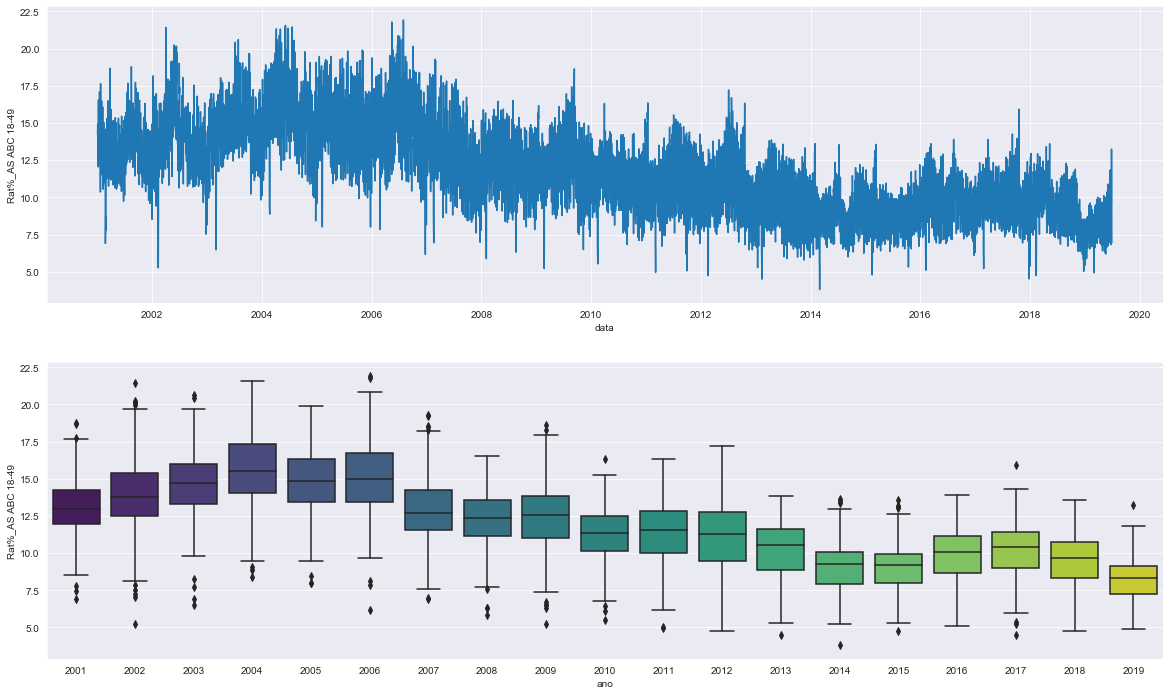

In [48]:
#Vizualização dos dados de TREINO
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,12), sharey = False)

sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data = df_3, ax=ax1)
sns.boxplot(x = 'ano', y = 'Rat%_AS ABC 18-49', data = df_3, palette='viridis', ax=ax2);

### df_4 - 24:00:00 - 29:59:00 (MADRUGADA)

### TREINO

In [49]:
# Separando a base para TREINO - jan/2001 a jun/2019
df_4 = df_all.loc[(df_all['daypart'] == '24:00:00 - 29:59:00') &
                  (df_all['data'] < '2019-07-01')]
df_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6663 entries, 3 to 28483
Data columns (total 6 columns):
emissora             6663 non-null object
data                 6663 non-null datetime64[ns]
daypart              6663 non-null object
Rat#_AS ABC 18-49    6663 non-null float64
Rat%_AS ABC 18-49    6663 non-null float64
ano                  6663 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 364.4+ KB


In [50]:
df_4.tail()

emissora       data              daypart  Rat#_AS ABC 18-49  \
28465    Globo 2019-06-26  24:00:00 - 29:59:00             701.88   
28469    Globo 2019-06-27  24:00:00 - 29:59:00             649.72   
28474    Globo 2019-06-28  24:00:00 - 29:59:00             512.53   
28478    Globo 2019-06-29  24:00:00 - 29:59:00             684.01   
28483    Globo 2019-06-30  24:00:00 - 29:59:00             703.21   

       Rat%_AS ABC 18-49   ano  
28465               2.38  2019  
28469               2.20  2019  
28474               1.73  2019  
28478               2.32  2019  
28483               2.38  2019

In [165]:
## Formatar a base para o modelo de entrada do Prophet:
# 1a coluna "ds" para os valores de data | 2a coluna "y" para a variável de medida (TRP)
df_4aj = df_4[['data', 'Rat%_AS ABC 18-49']]
df_4aj.columns = ['ds', 'y']

### TESTE

In [51]:
# Separando a base para TESTE - jul/2019 a set/2019
df_4_2019 = df_all.loc[(df_all['daypart'] == '24:00:00 - 29:59:00') &
                  (df_all['data'] >= '2019-07-01')]
df_4_2019.drop(['emissora', 'daypart', 'Rat#_AS ABC 18-49', 'ano'], axis=1, inplace=True)

## Formatar a base para o modelo de entrada do Prophet:
# 1a coluna "ds" para os valores de data | 2a coluna "y" para a variável de medida (TRP)
df_4_2019.columns = ['ds', 'y']

In [52]:
df_4_2019.info()
print(df_4_2019.head(3))
df_4_2019.tail(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 28487 to 28803
Data columns (total 2 columns):
ds    78 non-null datetime64[ns]
y     78 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB
              ds    y
28487 2019-07-01 2.07
28491 2019-07-02 1.92
28495 2019-07-03 1.99


ds    y
28795 2019-09-13 1.78
28799 2019-09-14 2.23
28803 2019-09-15 2.02

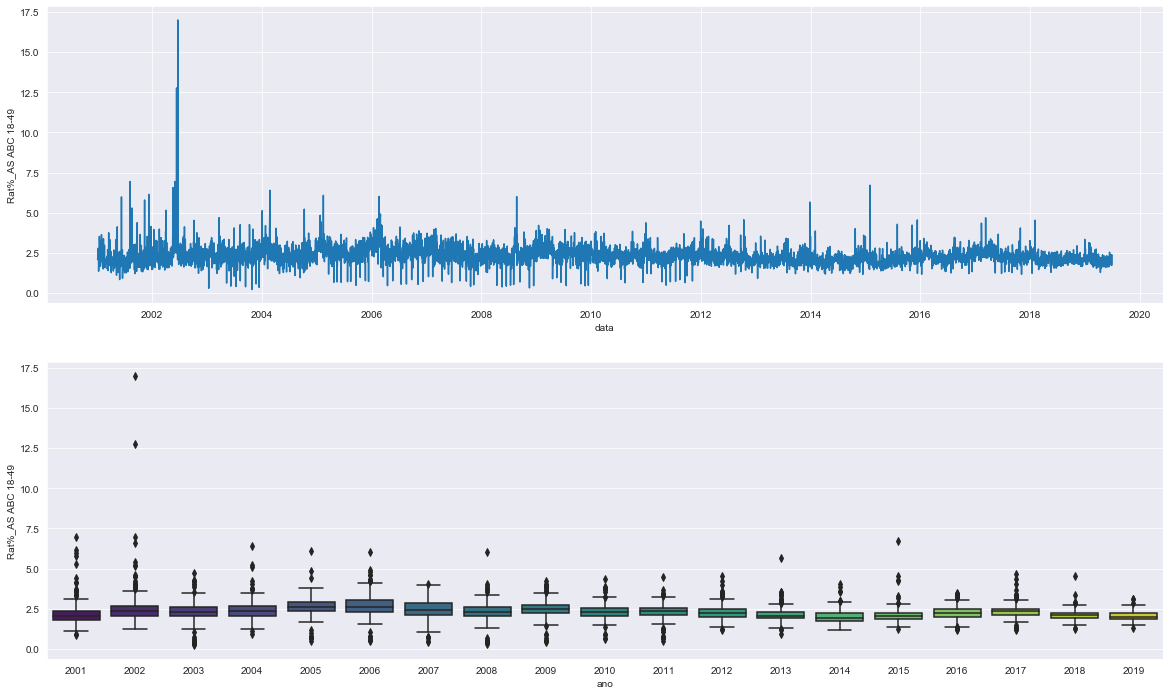

In [53]:
#Vizualização dos dados de TREINO
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,12), sharey = False)

sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data = df_4, ax=ax1)

sns.boxplot(x = 'ano', y = 'Rat%_AS ABC 18-49', data = df_4, palette='viridis', ax=ax2);

## Projeção TRP - sem mexer na base

### Modelo 1 - 06:00:00 - 11:59:00

In [55]:
#fit model_01: df_1 - 06:00:00 - 11:59:00 (MANHÃ)
m1 = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, holidays=holidays)
m1.add_country_holidays(country_name='BR')
m1.fit(df_1aj)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [57]:
future1 = m1.make_future_dataframe(periods=78)
future1.tail()

ds
6828 2019-09-12
6829 2019-09-13
6830 2019-09-14
6831 2019-09-15
6832 2019-09-16

In [58]:
forecast1 = m1.predict(future1)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds  yhat  yhat_lower  yhat_upper
6828 2019-09-12  2.83        1.51        4.16
6829 2019-09-13  2.81        1.41        4.22
6830 2019-09-14  2.50        1.09        3.77
6831 2019-09-15  3.99        2.57        5.27
6832 2019-09-16  2.85        1.42        4.25

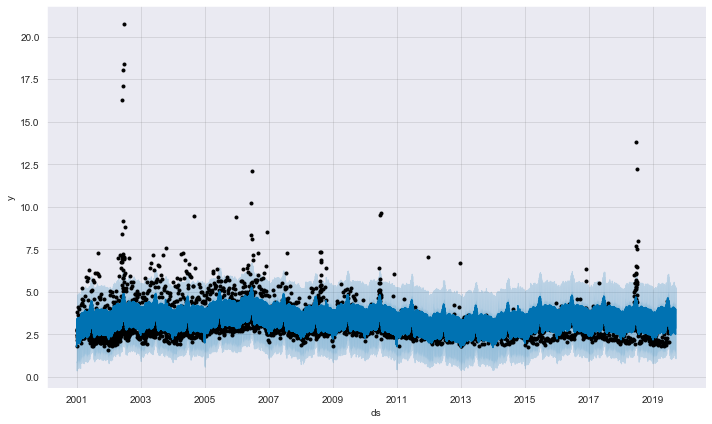

In [59]:
fig1_1 = m1.plot(forecast1)

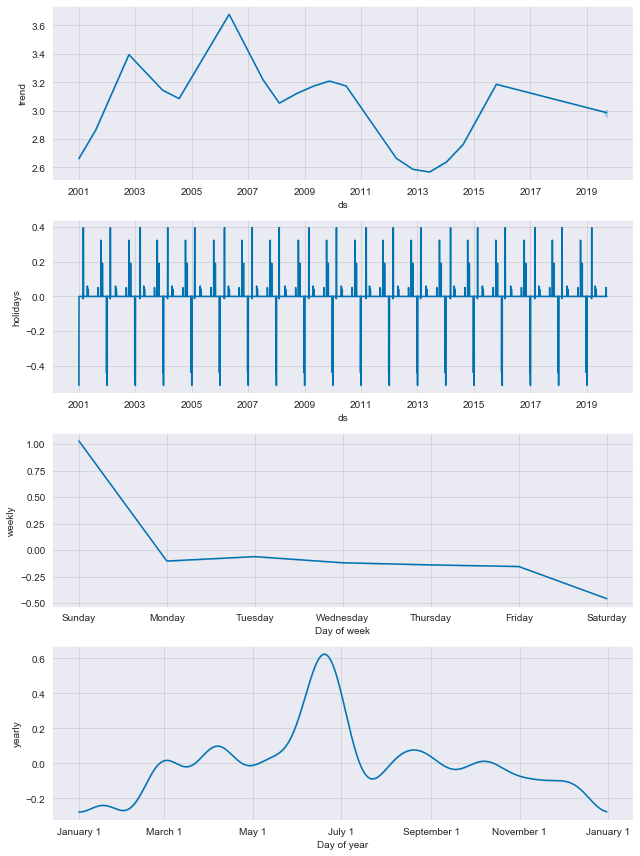

In [60]:
fig2_1 = m1.plot_components(forecast1)

In [62]:
#Calcular o erro do previsto x real
model_1 = forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [63]:
df_error_1 = model_1.loc[(model_1['ds'] >= '2019-07-01')]

In [64]:
df_error_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 6755 to 6832
Data columns (total 4 columns):
ds            78 non-null datetime64[ns]
yhat          78 non-null float64
yhat_lower    78 non-null float64
yhat_upper    78 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.0 KB


In [65]:
#criando a Base de validação
df_val_1 = pd.merge(df_error_1, df_1_2019, on='ds')

In [66]:
df_val_1['erro'] = df_val_1['y'] - df_val_1['yhat']

In [67]:
df_val_1.tail()

ds  yhat  yhat_lower  yhat_upper    y  erro
74 2019-09-12  2.83        1.51        4.16 3.01  0.18
75 2019-09-13  2.81        1.41        4.22 3.09  0.28
76 2019-09-14  2.50        1.09        3.77 2.22 -0.28
77 2019-09-15  3.99        2.57        5.27 3.16 -0.83
78 2019-09-16  2.85        1.42        4.25 2.90  0.05

In [68]:
df_val_1.describe()

yhat  yhat_lower  yhat_upper     y  erro
count 79.00       79.00       79.00 79.00 79.00
mean   3.04        1.65        4.43  2.95 -0.09
std    0.46        0.47        0.46  0.40  0.36
min    2.46        1.05        3.77  1.93 -0.97
25%    2.82        1.38        4.17  2.86 -0.32
50%    2.90        1.51        4.31  2.97  0.00
75%    3.00        1.65        4.43  3.14  0.16
max    4.23        2.84        5.59  4.64  0.67

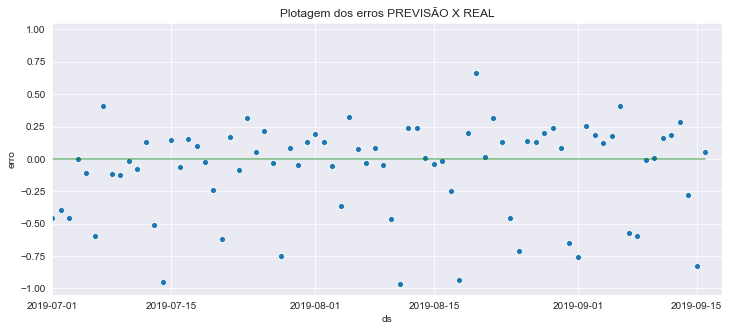

In [155]:
#Plot dos erros Previsão X REAL - jul/2019 a set/2019

fig, ax = plt.subplots(figsize=(12,5))
#plt.xlim('2019','2020')
sns.lineplot(x = 'ds', y = 0, data=df_val_1, color='green', alpha = 0.5)
sns.scatterplot(x='ds', y='erro', data=df_val_1)
ax.set_xlim(pd.Timestamp('2019-07-01'), pd.Timestamp('2019-09-18'))
ax.set_ylim(-1.05, 1.05)
ax.set_title('Plotagem dos erros PREVISÃO X REAL');

In [70]:
#Criando uma coluna de mês para identificar em qual dos meses de previsão existem os maiores erros
df_val_1['month'] = df_val_1['ds'].dt.month

In [71]:
df_val_1.tail()

ds  yhat  yhat_lower  yhat_upper    y  erro  month
74 2019-09-12  2.83        1.51        4.16 3.01  0.18      9
75 2019-09-13  2.81        1.41        4.22 3.09  0.28      9
76 2019-09-14  2.50        1.09        3.77 2.22 -0.28      9
77 2019-09-15  3.99        2.57        5.27 3.16 -0.83      9
78 2019-09-16  2.85        1.42        4.25 2.90  0.05      9

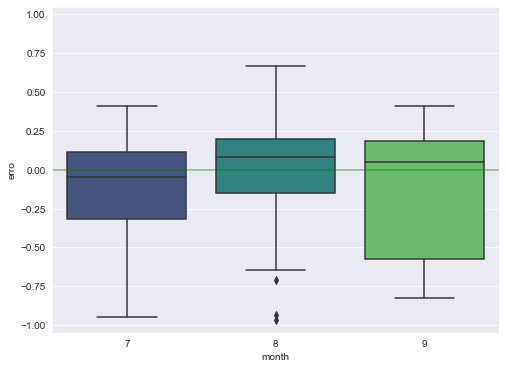

In [72]:
#Boxplot dos erros divididos por mês
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(x = [*range(-1,10)], y = 0, color='green', alpha = 0.5)
ax.set_ylim(-1.05, 1.05)
sns.boxplot(x='month', y='erro', data=df_val_1, palette='viridis');

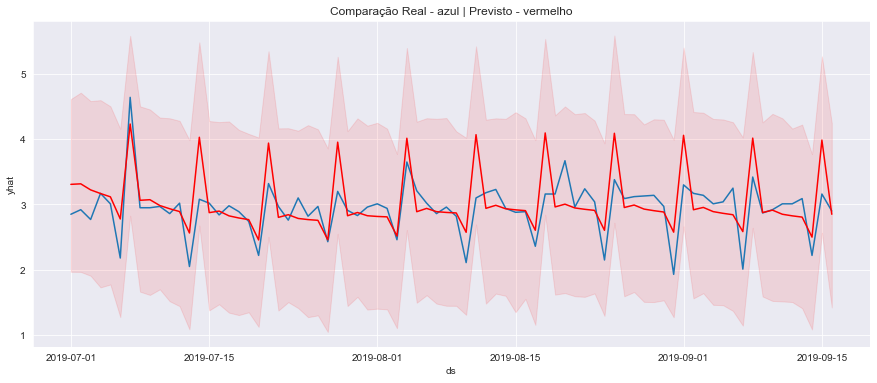

In [75]:
#Plot com o gráfico de PREVISÃO X REAL - com o intervalo de confiança de 95%
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x='ds', y='y', data=df_val_1)
sns.lineplot(x='ds', y='yhat', data=df_val_1, color='red', ci=95, err_style='band', ax=ax)
ax.fill_between(df_val_1['ds'],df_val_1['yhat_upper'], df_val_1['yhat_lower'], alpha=0.1, color='red')
ax.set_title('Comparação Real - azul | Previsto - vermelho');

## Fazendo alguns testes para melhorar a previsão

### Modelo 1a - 06:00:00 - 11:59:00 - Reduzindo o intervalo de confiança - e o changepoint_prior_scale=0.001

In [76]:
#fit model_01a
m1a = Prophet(interval_width=0.80, yearly_seasonality=True, weekly_seasonality=True, holidays=holidays,
              changepoint_prior_scale=0.001)
m1a.add_country_holidays(country_name='BR')
m1a.fit(df_1aj)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [77]:
future1a = m1a.make_future_dataframe(periods=78)
future1a.tail()

ds
6828 2019-09-12
6829 2019-09-13
6830 2019-09-14
6831 2019-09-15
6832 2019-09-16

In [78]:
forecast1a = m1a.predict(future1a)
forecast1a[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds  yhat  yhat_lower  yhat_upper
6828 2019-09-12  2.85        1.95        3.84
6829 2019-09-13  2.83        1.87        3.83
6830 2019-09-14  2.52        1.53        3.47
6831 2019-09-15  4.01        3.03        4.90
6832 2019-09-16  2.87        1.91        3.84

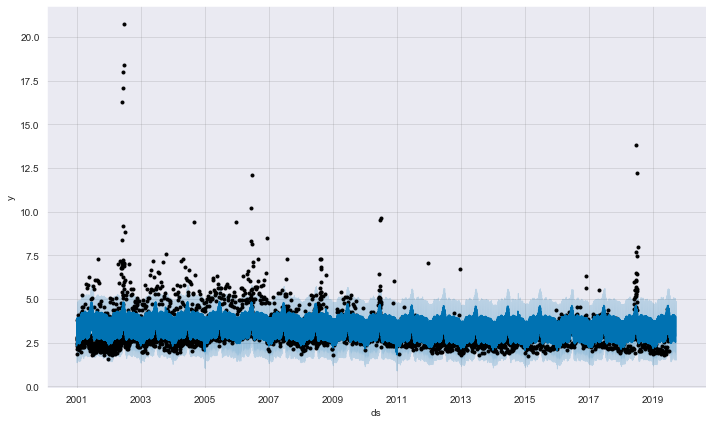

In [79]:
fig1_1a = m1a.plot(forecast1a)

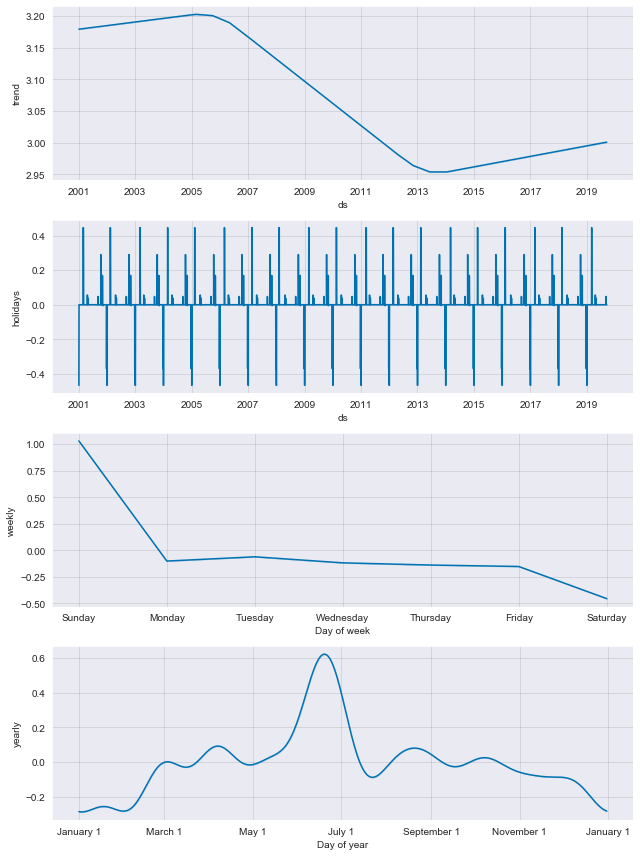

In [80]:
fig2_1a = m1a.plot_components(forecast1a)

In [81]:
model_1a = forecast1a[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [82]:
df_error_1a = model_1a.loc[(model_1a['ds'] >= '2019-07-01')]

In [83]:
df_error_1a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 6755 to 6832
Data columns (total 4 columns):
ds            78 non-null datetime64[ns]
yhat          78 non-null float64
yhat_lower    78 non-null float64
yhat_upper    78 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.0 KB


In [84]:
df_val_1a = pd.merge(df_error_1a, df_1_2019, on='ds')

In [85]:
df_val_1a['erro'] = df_val_1a['y'] - df_val_1a['yhat']

In [86]:
df_val_1a.tail()

ds  yhat  yhat_lower  yhat_upper    y  erro
74 2019-09-12  2.85        1.95        3.84 3.01  0.16
75 2019-09-13  2.83        1.87        3.83 3.09  0.26
76 2019-09-14  2.52        1.53        3.47 2.22 -0.30
77 2019-09-15  4.01        3.03        4.90 3.16 -0.85
78 2019-09-16  2.87        1.91        3.84 2.90  0.03

In [87]:
df_val_1a.describe()

yhat  yhat_lower  yhat_upper     y  erro
count 79.00       79.00       79.00 79.00 79.00
mean   3.05        2.10        4.02  2.95 -0.10
std    0.46        0.47        0.46  0.40  0.36
min    2.46        1.44        3.47  1.93 -0.98
25%    2.83        1.87        3.78  2.86 -0.34
50%    2.91        1.96        3.88  2.97 -0.01
75%    3.01        2.08        3.99  3.14  0.14
max    4.23        3.30        5.23  4.64  0.65

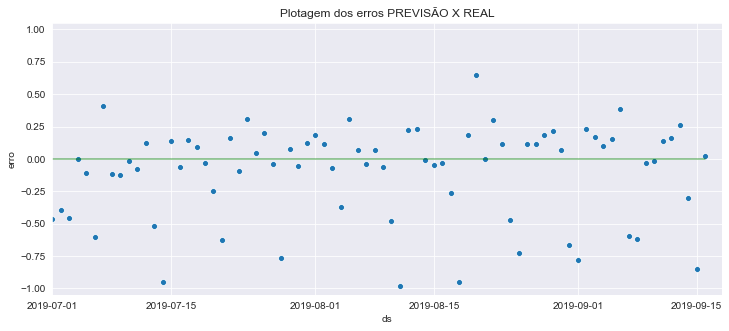

In [156]:
#Plot dos erros PREVISÃO X REAL
fig, ax = plt.subplots(figsize=(12,5))
#plt.xlim('2019','2020')
sns.lineplot(x = 'ds', y = 0, data=df_val_1a, color='green', alpha = 0.5)
sns.scatterplot(x='ds', y='erro', data=df_val_1a)
ax.set_xlim(pd.Timestamp('2019-07-01'), pd.Timestamp('2019-09-18'))
ax.set_ylim(-1.05, 1.05)
ax.set_title('Plotagem dos erros PREVISÃO X REAL');

In [89]:
df_val_1a['month'] = df_val_1a['ds'].dt.month

In [90]:
df_val_1a.tail()

ds  yhat  yhat_lower  yhat_upper    y  erro  month
74 2019-09-12  2.85        1.95        3.84 3.01  0.16      9
75 2019-09-13  2.83        1.87        3.83 3.09  0.26      9
76 2019-09-14  2.52        1.53        3.47 2.22 -0.30      9
77 2019-09-15  4.01        3.03        4.90 3.16 -0.85      9
78 2019-09-16  2.87        1.91        3.84 2.90  0.03      9

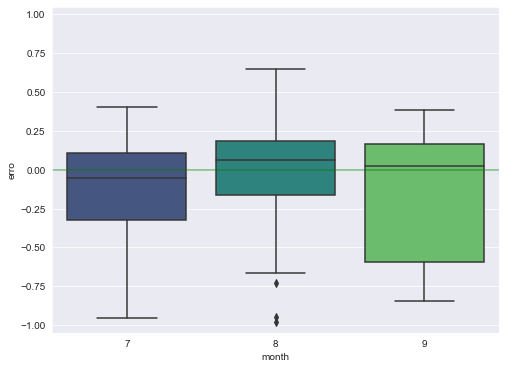

In [91]:
#Boxplot dos erros dividido por mês
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(x = [*range(-1,10)], y = 0, color='green', alpha = 0.5)
ax.set_ylim(-1.05, 1.05)
sns.boxplot(x='month', y='erro', data=df_val_1a, palette='viridis');

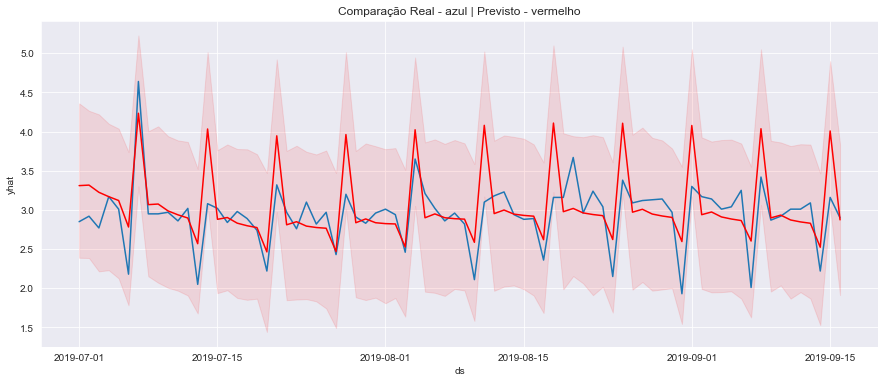

In [92]:
#Comparação dos valore PREVISÃO X REAL
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x='ds', y='y', data=df_val_1a)
sns.lineplot(x='ds', y='yhat', data=df_val_1a, color='red', ci=95, err_style='band', ax=ax)
ax.fill_between(df_val_1a['ds'],df_val_1a['yhat_upper'], df_val_1a['yhat_lower'], alpha=0.1, color='red')
ax.set_title('Comparação Real - azul | Previsto - vermelho');

### Modelo 1b - 06:00:00 - 11:59:00 - retirando os principais outliers
"The best way to handle outliers is to remove them - Prophet has no problem with missing data. If you set their values to NA in the history but leave the dates in future, then Prophet will give you a prediction for their values." (PROPHET doc)

In [93]:
#Anos com outlier: 2002 - 2006 - 2010 - 2018

In [94]:
df_1baj = df_1[['data', 'Rat%_AS ABC 18-49']]
df_1baj.columns = ['ds', 'y']

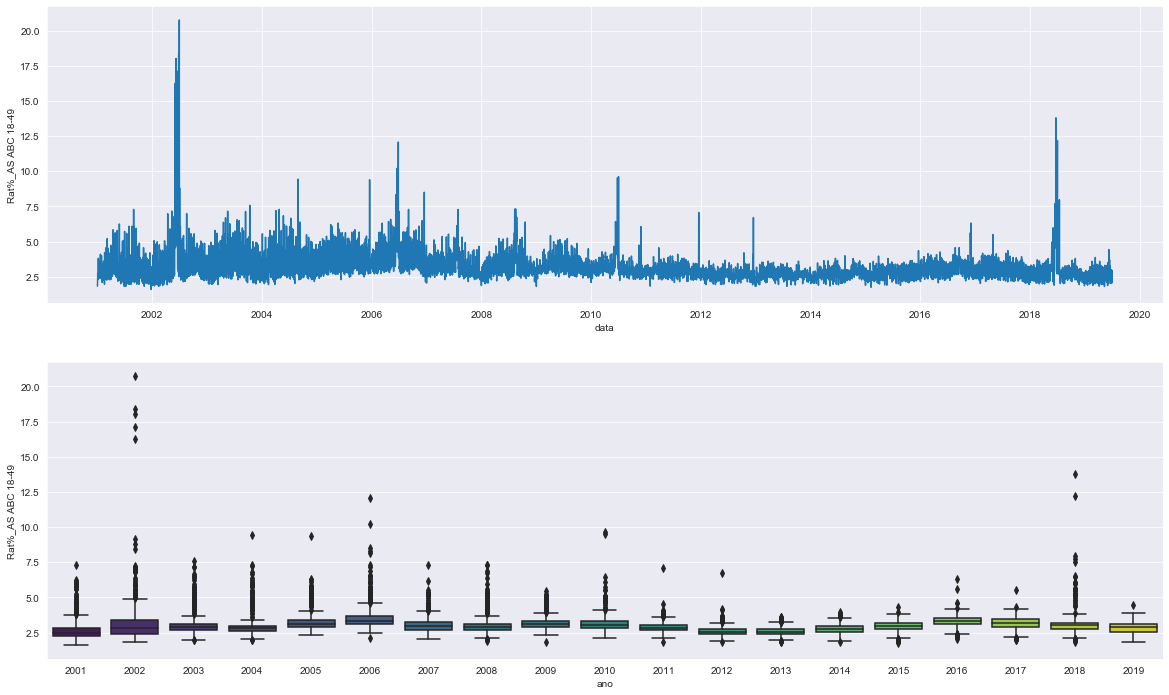

In [95]:
#Vizualização dos dados
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,12), sharey = False)

sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data = df_1, ax=ax1)
sns.boxplot(x = 'ano', y = 'Rat%_AS ABC 18-49', data = df_1, palette='viridis', ax=ax2);

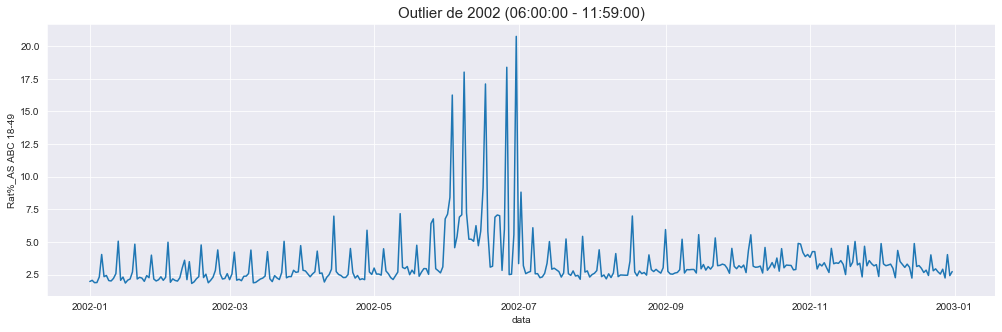

In [96]:
fig, ax1 = plt.subplots(figsize=(17,5))
sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data=df_1.loc[(df_1['ano'] == 2002)], ax=ax1)
ax1.set_title('Outlier de 2002 (06:00:00 - 11:59:00)', size=15);

In [97]:
df_1baj.loc[(df_1baj['ds'] > '2002-06-01') & (df_1aj['ds'] < '2002-07-10'), 'y'] = None

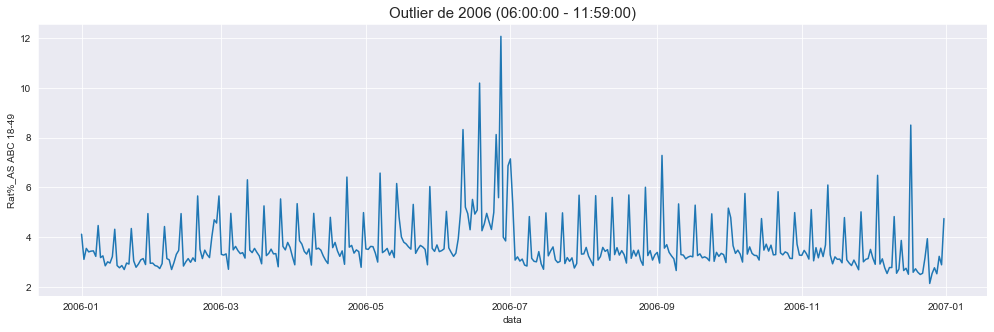

In [98]:
fig, ax1 = plt.subplots(figsize=(17,5))
sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data=df_1.loc[(df_1['ano'] == 2006)], ax=ax1)
ax1.set_title('Outlier de 2006 (06:00:00 - 11:59:00)', size=15);

In [99]:
df_1baj.loc[(df_1baj['ds'] > '2006-06-01') & (df_1aj['ds'] < '2002-07-10'), 'y'] = None

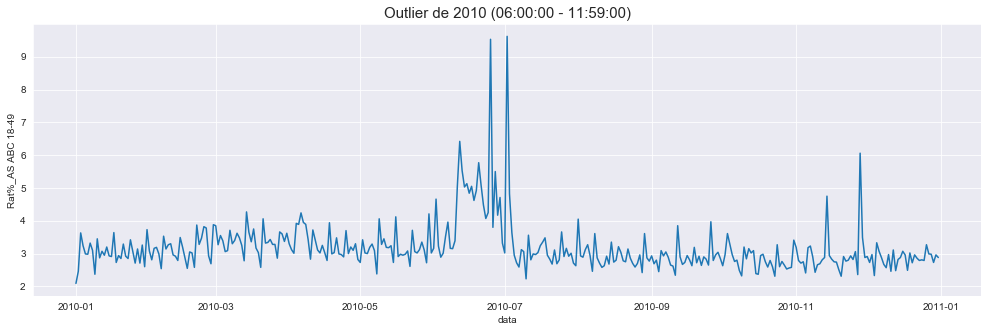

In [100]:
fig, ax1 = plt.subplots(figsize=(17,5))
sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data=df_1.loc[(df_1['ano'] == 2010)], ax=ax1)
ax1.set_title('Outlier de 2010 (06:00:00 - 11:59:00)', size=15);

In [101]:
df_1baj.loc[(df_1baj['ds'] > '2010-06-01') & (df_1aj['ds'] < '2010-07-10'), 'y'] = None

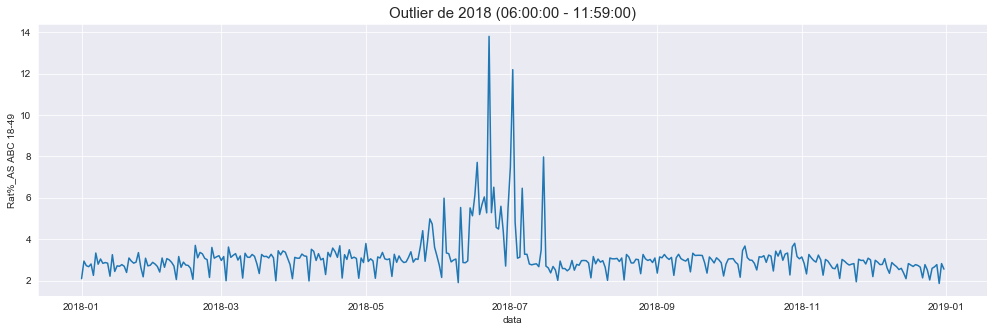

In [102]:
fig, ax1 = plt.subplots(figsize=(17,5))
sns.lineplot(x= 'data', y = 'Rat%_AS ABC 18-49', data=df_1.loc[(df_1['ano'] == 2018)], ax=ax1)
ax1.set_title('Outlier de 2018 (06:00:00 - 11:59:00)', size=15);

In [103]:
df_1baj.loc[(df_1baj['ds'] > '2018-06-01') & (df_1aj['ds'] < '2018-07-20'), 'y'] = None

In [104]:
#fit model_01b - sem os Outliers e intervalo de confiança 95%

m1b = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, holidays=holidays,
              changepoint_prior_scale=0.001)
m1b.add_country_holidays(country_name='BR')
m1b.fit(df_1baj)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [105]:
future1b = m1a.make_future_dataframe(periods=78)
future1b.tail()

ds
6828 2019-09-12
6829 2019-09-13
6830 2019-09-14
6831 2019-09-15
6832 2019-09-16

In [106]:
forecast1b = m1b.predict(future1b)
forecast1b[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds  yhat  yhat_lower  yhat_upper
6828 2019-09-12  2.81        1.78        3.92
6829 2019-09-13  2.77        1.64        3.86
6830 2019-09-14  2.46        1.33        3.52
6831 2019-09-15  3.94        2.93        5.02
6832 2019-09-16  2.81        1.74        3.92

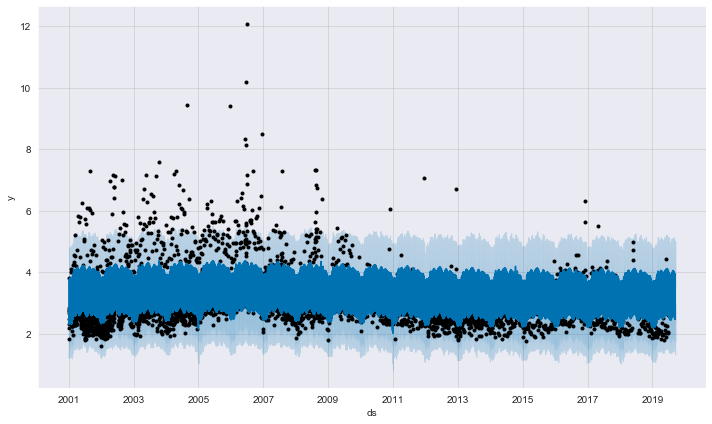

In [107]:
fig1_1b = m1b.plot(forecast1b)

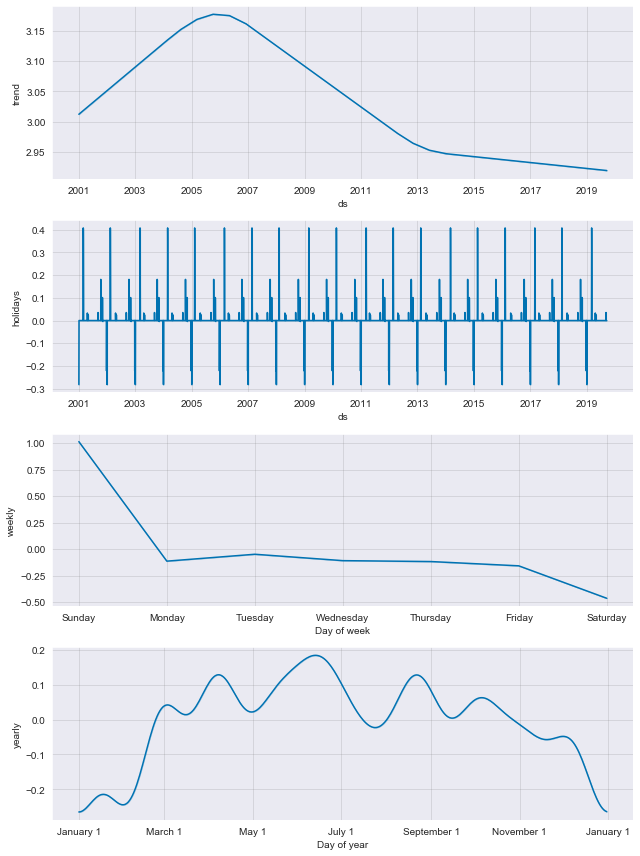

In [108]:
fig2_1b = m1b.plot_components(forecast1b)

In [109]:
model_1b = forecast1b[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [110]:
df_error_1b = model_1b.loc[(model_1b['ds'] >= '2019-07-01')]

In [111]:
df_error_1b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 6755 to 6832
Data columns (total 4 columns):
ds            78 non-null datetime64[ns]
yhat          78 non-null float64
yhat_lower    78 non-null float64
yhat_upper    78 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.0 KB


In [112]:
df_val_1b = pd.merge(df_error_1b, df_1_2019, on='ds')

In [113]:
df_val_1b['erro'] = df_val_1b['y'] - df_val_1b['yhat']

In [114]:
df_val_1b.tail()

ds  yhat  yhat_lower  yhat_upper    y  erro
74 2019-09-12  2.81        1.78        3.92 3.01  0.20
75 2019-09-13  2.77        1.64        3.86 3.09  0.32
76 2019-09-14  2.46        1.33        3.52 2.22 -0.24
77 2019-09-15  3.94        2.93        5.02 3.16 -0.78
78 2019-09-16  2.81        1.74        3.92 2.90  0.09

In [115]:
df_val_1b.describe()

yhat  yhat_lower  yhat_upper     y  erro
count 79.00       79.00       79.00 79.00 79.00
mean   2.98        1.91        4.06  2.95 -0.03
std    0.45        0.46        0.45  0.40  0.35
min    2.43        1.33        3.50  1.93 -0.90
25%    2.79        1.71        3.86  2.86 -0.17
50%    2.86        1.80        3.93  2.97  0.04
75%    2.93        1.86        4.03  3.14  0.19
max    4.06        3.11        5.13  4.64  0.67

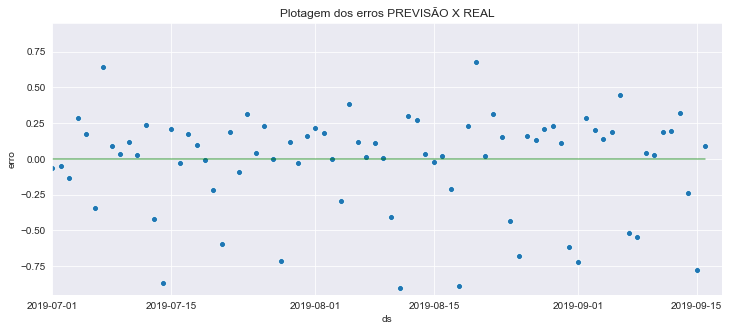

In [157]:
#Plot dos erros PREVISÃO X REAL
fig, ax = plt.subplots(figsize=(12,5))
#plt.xlim('2019','2020')
sns.lineplot(x = 'ds', y = 0, data=df_val_1b, color='green', alpha = 0.5)
sns.scatterplot(x='ds', y='erro', data=df_val_1b)
ax.set_xlim(pd.Timestamp('2019-07-01'), pd.Timestamp('2019-09-18'))
ax.set_ylim(-.95, .95)
ax.set_title('Plotagem dos erros PREVISÃO X REAL');

In [118]:
df_val_1b['month'] = df_val_1b['ds'].dt.month

In [119]:
df_val_1b.tail()

ds  yhat  yhat_lower  yhat_upper    y  erro  month
74 2019-09-12  2.81        1.78        3.92 3.01  0.20      9
75 2019-09-13  2.77        1.64        3.86 3.09  0.32      9
76 2019-09-14  2.46        1.33        3.52 2.22 -0.24      9
77 2019-09-15  3.94        2.93        5.02 3.16 -0.78      9
78 2019-09-16  2.81        1.74        3.92 2.90  0.09      9

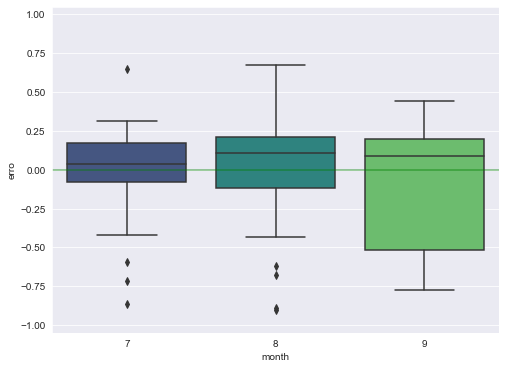

In [121]:
#Boxplot dos erros dividido por mês
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(x = [*range(-1,10)], y = 0, color='green', alpha = 0.5)
ax.set_ylim(-1.05, 1.05)
sns.boxplot(x='month', y='erro', data=df_val_1b, palette='viridis');

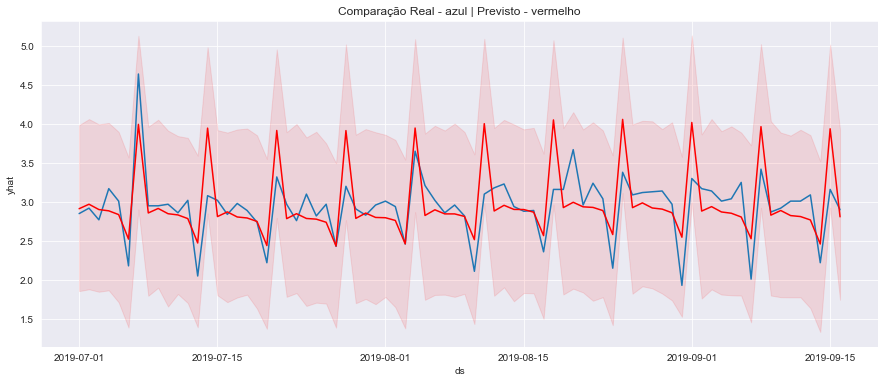

In [122]:
#Plot dos valores de PREVISÃO X REAL
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x='ds', y='y', data=df_val_1b)
sns.lineplot(x='ds', y='yhat', data=df_val_1b, color='red', ax=ax)
ax.fill_between(df_val_1b['ds'],df_val_1b['yhat_upper'], df_val_1b['yhat_lower'], alpha=0.1, color='red')
ax.set_title('Comparação Real - azul | Previsto - vermelho');

### Modelo 2 - 12:00:00 - 17:59:00 - sem mexer na base

In [124]:
#fit model_02: DAYPART 12:00:00 - 17:59:00 (TARDE)
m2 = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, holidays=holidays)
m2.add_country_holidays(country_name='BR')
m2.fit(df_2aj)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [125]:
future2 = m2.make_future_dataframe(periods=78)
future2.tail()

ds
6828 2019-09-12
6829 2019-09-13
6830 2019-09-14
6831 2019-09-15
6832 2019-09-16

In [126]:
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds  yhat  yhat_lower  yhat_upper
6828 2019-09-12  4.95        2.99        6.68
6829 2019-09-13  4.74        2.90        6.61
6830 2019-09-14  4.38        2.48        6.29
6831 2019-09-15  6.25        4.42        8.08
6832 2019-09-16  5.27        3.43        7.05

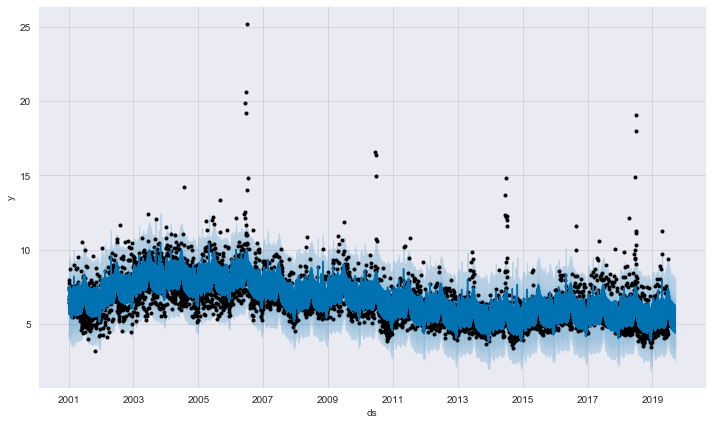

In [127]:
fig1_2 = m2.plot(forecast2)

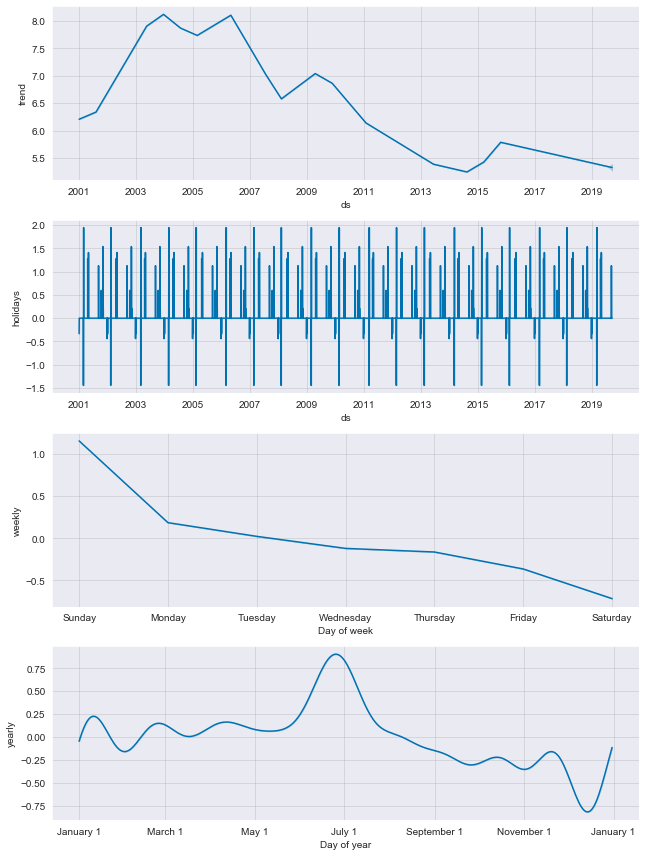

In [128]:
fig2_2 = m2.plot_components(forecast2)

In [129]:
model_2 = forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [130]:
df_error_2 = model_2.loc[(model_2['ds'] >= '2019-07-01')]

In [131]:
df_error_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 6755 to 6832
Data columns (total 4 columns):
ds            78 non-null datetime64[ns]
yhat          78 non-null float64
yhat_lower    78 non-null float64
yhat_upper    78 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.0 KB


In [132]:
df_val_2 = pd.merge(df_error_2, df_2_2019, on='ds')

In [133]:
df_val_2['erro'] = df_val_2['y'] - df_val_2['yhat']

In [134]:
df_val_2.tail()

ds  yhat  yhat_lower  yhat_upper    y  erro
73 2019-09-11  5.01        3.10        6.74 4.79 -0.22
74 2019-09-12  4.95        2.99        6.68 4.68 -0.27
75 2019-09-13  4.74        2.90        6.61 4.96  0.22
76 2019-09-14  4.38        2.48        6.29 4.60  0.22
77 2019-09-15  6.25        4.42        8.08 6.52  0.27

In [135]:
df_val_2.describe()

yhat  yhat_lower  yhat_upper     y  erro
count 78.00       78.00       78.00 78.00 78.00
mean   5.47        3.63        7.28  5.27 -0.20
std    0.62        0.61        0.62  1.27  0.95
min    4.38        2.48        6.29  3.95 -1.62
25%    5.06        3.19        6.88  4.70 -0.65
50%    5.34        3.48        7.13  4.98 -0.30
75%    5.78        3.96        7.59  5.25  0.08
max    7.18        5.35        9.05 13.51  6.33

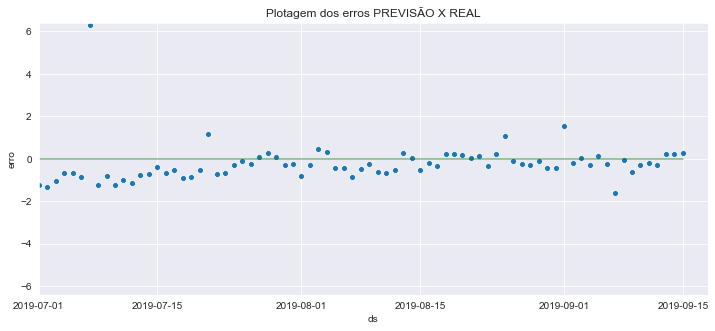

In [158]:
#Plot dos erros PREVISÃO X REAL
fig, ax = plt.subplots(figsize=(12,5))
#plt.xlim('2019','2020')
sns.lineplot(x = 'ds', y = 0, data=df_val_2, color='green', alpha = 0.5)
sns.scatterplot(x='ds', y='erro', data=df_val_2)
ax.set_xlim(pd.Timestamp('2019-07-01'), pd.Timestamp('2019-09-18'))
ax.set_ylim(-6.40, 6.40)
ax.set_title('Plotagem dos erros PREVISÃO X REAL');

In [137]:
df_val_2['month'] = df_val_2['ds'].dt.month

In [139]:
df_val_2.head()

ds  yhat  yhat_lower  yhat_upper    y  erro  month
0 2019-07-01  6.39        4.41        8.23 5.18 -1.21      7
1 2019-07-02  6.20        4.39        7.87 4.88 -1.32      7
2 2019-07-03  6.03        4.28        7.77 5.00 -1.03      7
3 2019-07-04  5.96        4.22        7.74 5.31 -0.65      7
4 2019-07-05  5.73        3.93        7.55 5.08 -0.65      7

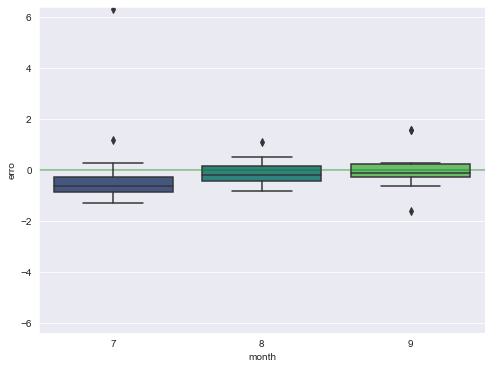

In [140]:
#Boxplot dor erros PREVISÃO X REAL - dividido por mês
#Os maiores erros estão concentradoos em Junho - o que pode ser resultado dos outliers de copa do mundo de 2002
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(x = [*range(-1,10)], y = 0, color='green', alpha = 0.5)
ax.set_ylim(-6.40, 6.40);
sns.boxplot(x='month', y='erro', data=df_val_2, palette='viridis');

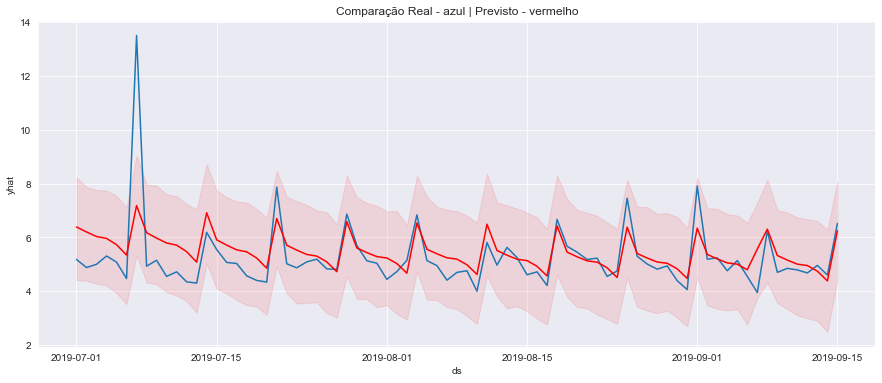

In [141]:
#Plot dos valore PREVISÃO X REAL
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x='ds', y='y', data=df_val_2)
sns.lineplot(x='ds', y='yhat', data=df_val_2, color='red', ci=95, err_style='band', ax=ax)
ax.fill_between(df_val_2['ds'],df_val_2['yhat_upper'], df_val_2['yhat_lower'], alpha=0.1, color='red')
ax.set_title('Comparação Real - azul | Previsto - vermelho');

### Observação

O pico de 07-07-2019 foi a Final da Copa do Mundo Feminina (EUA - Holanda) Domingo. O modelo gerou a previsão de aumento de audiência nesse horário - Jogos de Domingo, mas a Final de uma Copa do Mundo representa um outlier que não consegue ser prenvisto pelo modelo.

### Modelo 3 - 18:00:00 - 22:59:00 -  Sem mexer na base

In [143]:
#fit model_03: DAYPART 18:00:00 - 22:59:00 (NOITE)
m3 = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, holidays=holidays)
m3.add_country_holidays(country_name='BR')
m3.fit(df_3aj)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [144]:
future3 = m3.make_future_dataframe(periods=78)
future3.tail()

ds
6827 2019-09-12
6828 2019-09-13
6829 2019-09-14
6830 2019-09-15
6831 2019-09-16

In [145]:
forecast3 = m3.predict(future3)
forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds  yhat  yhat_lower  yhat_upper
6827 2019-09-12  9.98        7.08       12.63
6828 2019-09-13  9.08        6.44       11.92
6829 2019-09-14  7.78        5.16       10.65
6830 2019-09-15  7.25        4.46        9.90
6831 2019-09-16 11.26        8.43       14.15

Previsão dos valores desde 2001 a 2019 - DAYPART: 18:00:00 - 22:59:00


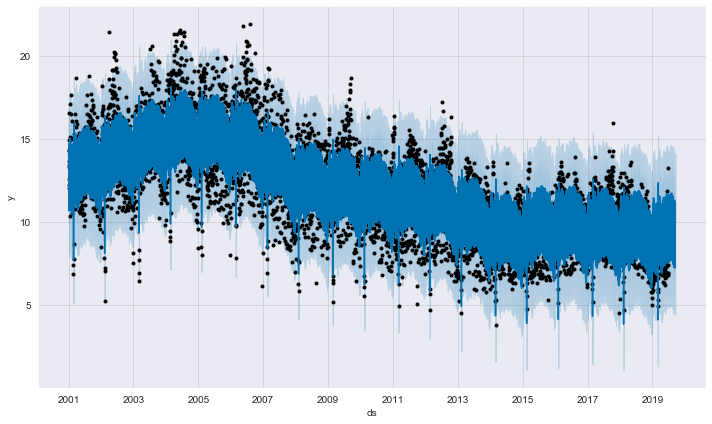

In [146]:
print('Previsão dos valores desde 2001 a 2019 - DAYPART: 18:00:00 - 22:59:00')
fig1_3 = m3.plot(forecast3)

Previsão dos valores desde 2001 a 2019 - DAYPART: 18:00:00 - 22:59:00 - TENDENCIA


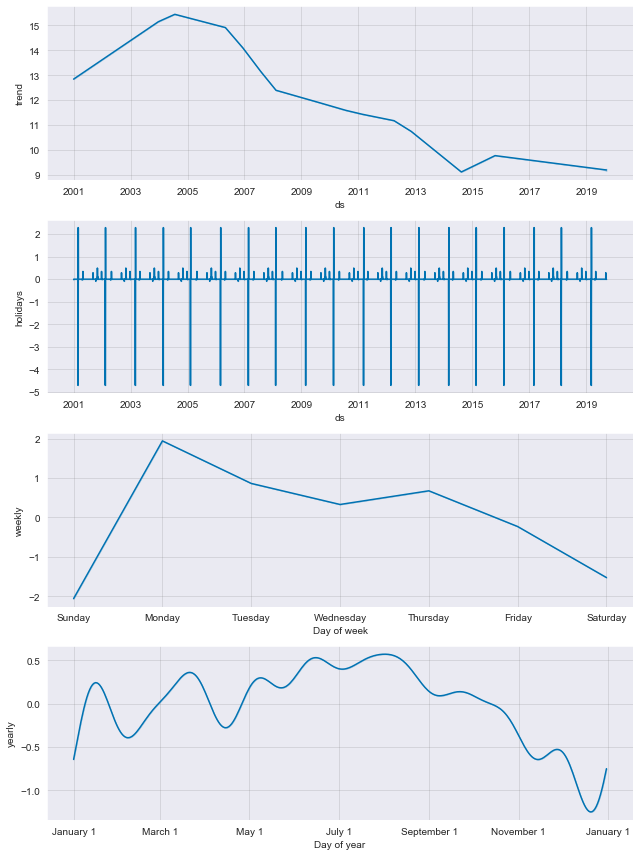

In [147]:
print('Previsão dos valores desde 2001 a 2019 - DAYPART: 18:00:00 - 22:59:00 - TENDENCIA')
fig2_3 = m3.plot_components(forecast3)

In [148]:
model_3 = forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [149]:
df_error_3 = model_3.loc[(model_3['ds'] >= '2019-07-01')]

In [150]:
df_error_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 6754 to 6831
Data columns (total 4 columns):
ds            78 non-null datetime64[ns]
yhat          78 non-null float64
yhat_lower    78 non-null float64
yhat_upper    78 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.0 KB


In [151]:
df_val_3 = pd.merge(df_error_3, df_3_2019, on='ds')

In [152]:
df_val_3['erro'] = df_val_3['y'] - df_val_3['yhat']

In [153]:
df_val_3.describe()

yhat  yhat_lower  yhat_upper     y  erro
count 78.00       78.00       78.00 78.00 78.00
mean   9.58        6.81       12.35  9.59  0.01
std    1.34        1.33        1.37  1.70  0.89
min    7.23        4.45        9.90  6.12 -1.57
25%    8.22        5.52       10.92  8.07 -0.59
50%    9.97        7.05       12.65  9.89 -0.11
75%   10.46        7.67       13.27 10.95  0.52
max   11.73        9.13       14.64 13.98  3.48

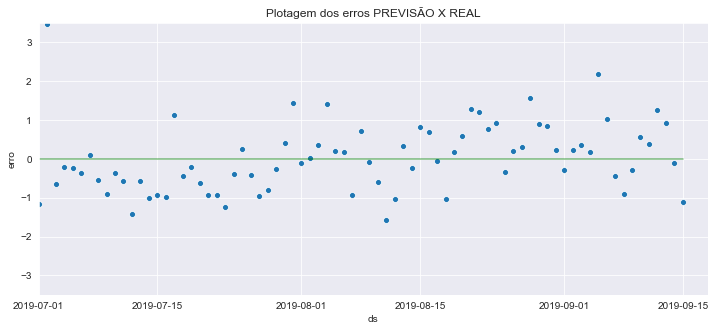

In [159]:
#Plot dos erros de PREVISÃO X REAL

fig, ax = plt.subplots(figsize=(12,5))
#plt.xlim('2019','2020')
sns.lineplot(x = 'ds', y = 0, data=df_val_3, color='green', alpha = 0.5)
sns.scatterplot(x='ds', y='erro', data=df_val_3)
ax.set_xlim(pd.Timestamp('2019-07-01'), pd.Timestamp('2019-09-18'))
ax.set_ylim(-3.50, 3.50)
ax.set_title('Plotagem dos erros PREVISÃO X REAL');

In [160]:
df_val_3['month'] = df_val_3['ds'].dt.month

In [161]:
df_val_3.tail()

ds  yhat  yhat_lower  yhat_upper     y  erro  month
73 2019-09-11  9.63        6.89       12.50 10.00  0.37      9
74 2019-09-12  9.98        7.08       12.63 11.25  1.27      9
75 2019-09-13  9.08        6.44       11.92 10.00  0.92      9
76 2019-09-14  7.78        5.16       10.65  7.69 -0.09      9
77 2019-09-15  7.25        4.46        9.90  6.15 -1.10      9

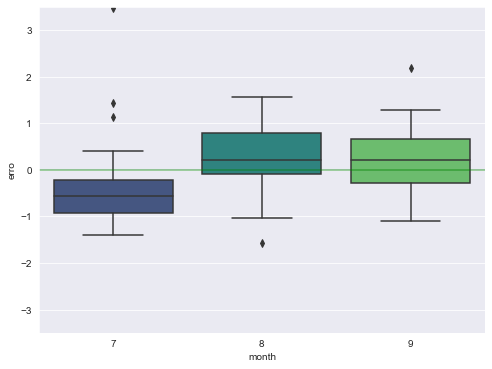

In [162]:
#Boxplot erros PREVISÃO X REAL - dividido por mês

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlim(1,9)
ax.set_ylim(-3.50, 3.50);
sns.boxplot(x='month', y='erro', data=df_val_3, palette='viridis')
sns.lineplot(x=[*range(-1,10)], y=0, color='green', alpha = 0.5);

O valor real está dentro do intervalo de confiança do modelo, sendo que os maiores erros acontecem de jan-mar


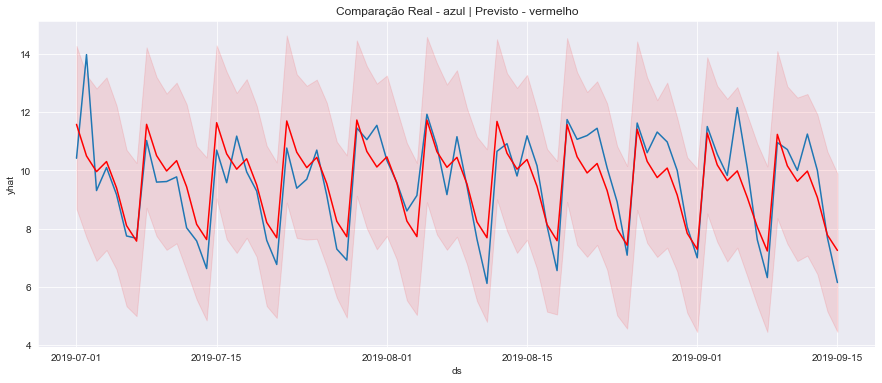

In [164]:
#Plot valores PREVISÃO X REAL
print('O valor real está dentro do intervalo de confiança do modelo, sendo que os maiores erros acontecem de jan-mar')
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x='ds', y='y', data=df_val_3)
sns.lineplot(x='ds', y='yhat', data=df_val_3, color='red', ax=ax)
ax.fill_between(df_val_3['ds'],df_val_3['yhat_upper'], df_val_3['yhat_lower'], alpha=0.1, color='red')
ax.set_title('Comparação Real - azul | Previsto - vermelho');

### Modelo 4 - 24:00:00 - 29:59:00 (MADRUGADA) - sem mexer na base

In [166]:
#fit the model_04
m4 = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, holidays=holidays)
m4.add_country_holidays(country_name='BR')
m4.fit(df_4aj)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [167]:
future4 = m4.make_future_dataframe(periods=78)
future4.tail()

ds
6736 2019-09-12
6737 2019-09-13
6738 2019-09-14
6739 2019-09-15
6740 2019-09-16

In [168]:
forecast4 = m4.predict(future4)
forecast4[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds  yhat  yhat_lower  yhat_upper
6736 2019-09-12  1.94        0.93        2.87
6737 2019-09-13  2.15        1.12        3.12
6738 2019-09-14  2.28        1.22        3.32
6739 2019-09-15  1.93        0.85        3.03
6740 2019-09-16  2.11        1.00        3.16

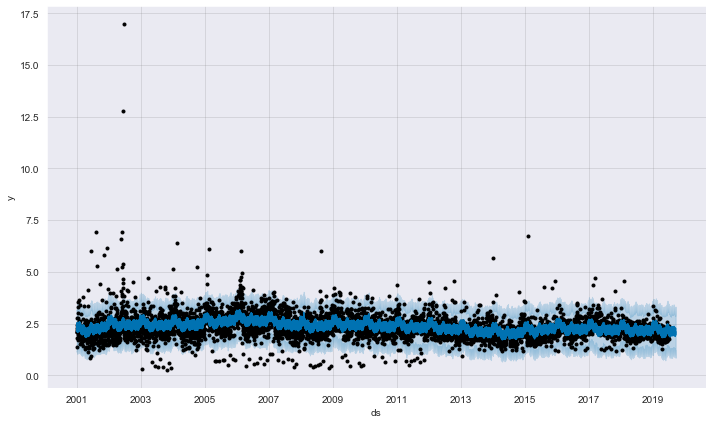

In [169]:
fig1_4 = m4.plot(forecast4)

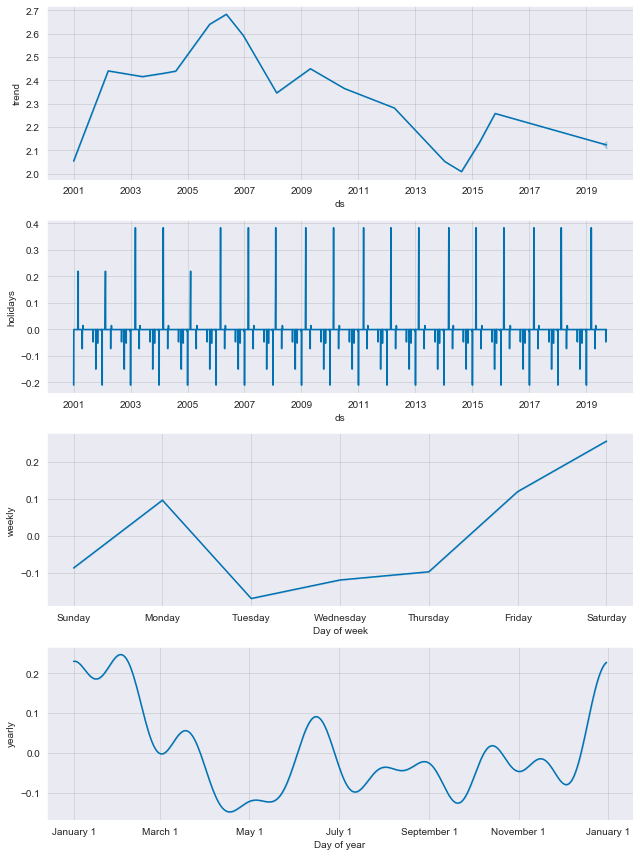

In [170]:
fig2_4 = m4.plot_components(forecast4)

In [171]:
model_4 = forecast4[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [172]:
df_error_4 = model_4.loc[(model_4['ds'] >= '2019-07-01')]

In [173]:
df_error_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 6663 to 6740
Data columns (total 4 columns):
ds            78 non-null datetime64[ns]
yhat          78 non-null float64
yhat_lower    78 non-null float64
yhat_upper    78 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.0 KB


In [174]:
df_val_4 = pd.merge(df_error_4, df_4_2019, on='ds')

In [175]:
df_val_4.tail()

ds  yhat  yhat_lower  yhat_upper    y
73 2019-09-11  1.93        0.96        2.96 1.97
74 2019-09-12  1.94        0.93        2.87 2.46
75 2019-09-13  2.15        1.12        3.12 1.78
76 2019-09-14  2.28        1.22        3.32 2.23
77 2019-09-15  1.93        0.85        3.03 2.02

In [176]:
df_val_4['erro'] = df_val_4['y'] - df_val_4['yhat']

In [177]:
df_val_4.describe()

yhat  yhat_lower  yhat_upper     y  erro
count 78.00       78.00       78.00 78.00 78.00
mean   2.07        1.06        3.09  2.10  0.02
std    0.15        0.15        0.15  0.26  0.28
min    1.87        0.84        2.83  1.58 -0.48
25%    1.95        0.94        2.96  1.91 -0.13
50%    2.00        1.00        3.03  2.06 -0.02
75%    2.20        1.18        3.23  2.25  0.12
max    2.36        1.36        3.43  3.19  1.31

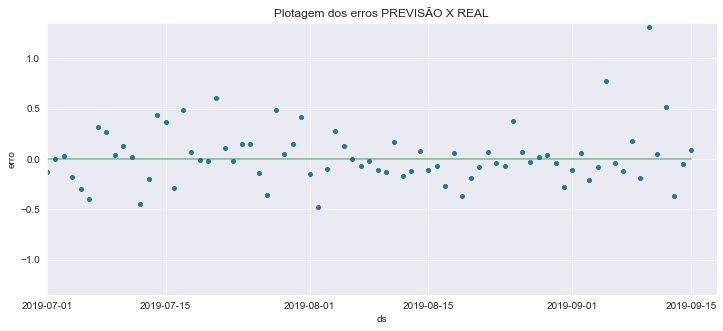

In [178]:
#Plot dos erros PREVISÃO X REAL

fig, ax = plt.subplots(figsize=(12,5))
#plt.xlim('2019','2020')
sns.scatterplot(x='ds', y='erro', data=df_val_4)
sns.lineplot(x = 'ds', y = 0, data=df_val_4, color='green', alpha = 0.5)
ax.set_xlim(pd.Timestamp('2019-07-01'), pd.Timestamp('2019-09-18'))
ax.set_ylim(-1.35, 1.35)
ax.set_title('Plotagem dos erros PREVISÃO X REAL');

In [179]:
df_val_4['month'] = df_val_4['ds'].dt.month

In [180]:
df_val_4.tail()

ds  yhat  yhat_lower  yhat_upper    y  erro  month
73 2019-09-11  1.93        0.96        2.96 1.97  0.04      9
74 2019-09-12  1.94        0.93        2.87 2.46  0.52      9
75 2019-09-13  2.15        1.12        3.12 1.78 -0.37      9
76 2019-09-14  2.28        1.22        3.32 2.23 -0.05      9
77 2019-09-15  1.93        0.85        3.03 2.02  0.09      9

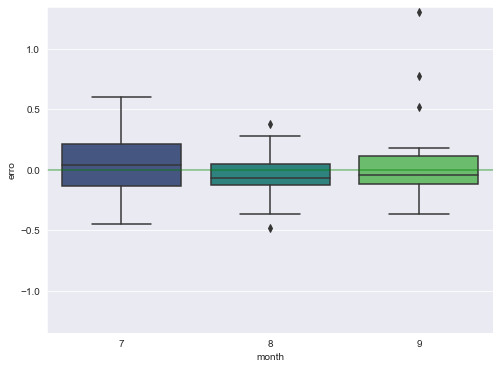

In [181]:
#Boxplot dos erros PREVISÃO X REAL - divididos por mês

fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(x = [*range(-1,10)], y = 0, color='green', alpha = 0.5)
ax.set_ylim(-1.35, 1.35);
sns.boxplot(x='month', y='erro', data=df_val_4, palette='viridis');

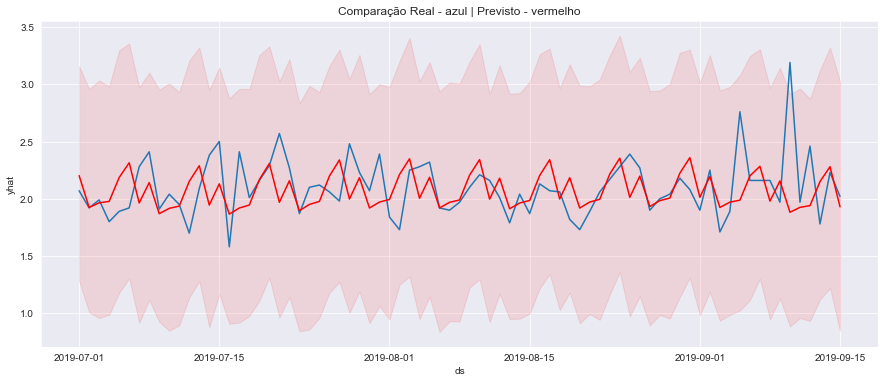

In [183]:
#Plot dos valores de PREVISÃO X REAL
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x='ds', y='y', data=df_val_4)
sns.lineplot(x='ds', y='yhat', data=df_val_4, color='red', ci=95, err_style='band', ax=ax)
ax.fill_between(df_val_4['ds'],df_val_4['yhat_upper'], df_val_4['yhat_lower'], alpha=0.1, color='red')
ax.set_title('Comparação Real - azul | Previsto - vermelho');

In [121]:
# df_val_2.to_excel('Modelo2_noite_R01.xls')

### Correção dos outliers MANUAL
- Usando o exemplo da Madrugada para ver se os valores de previsão ficam melhores


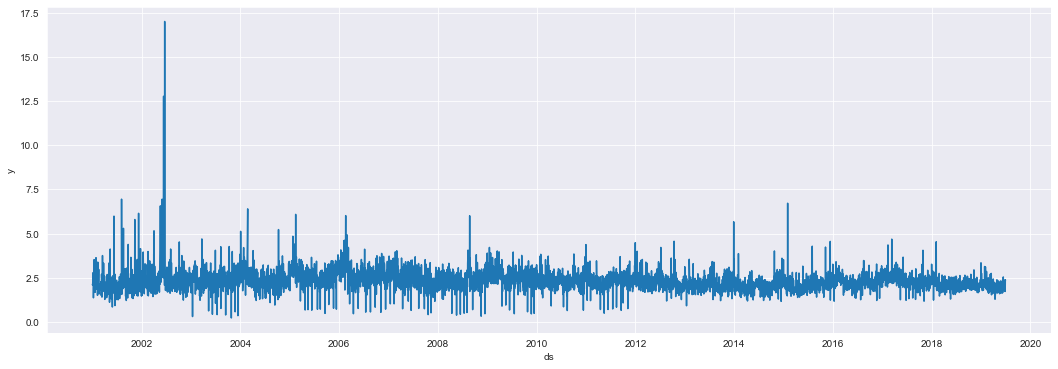

In [122]:
fig, ax = plt.subplots(figsize=(18,6))
sns.lineplot(x='ds', y='y', data=df_4aj)

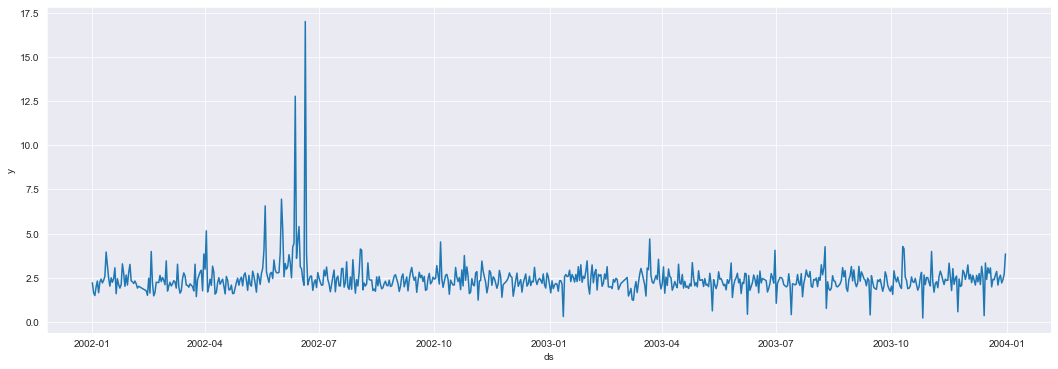

In [123]:
fig, ax = plt.subplots(figsize=(18,6))
sns.lineplot(x='ds', y='y', data=df_4aj.loc[(df_4aj['ds'] >= '01-01-2002') &
                                            (df_4aj['ds'] <= '31-12-2003')])

In [124]:
#df_4out.to_excel('df_4out.xls')

In [125]:
df_4out = pd.read_excel('df_4out.xls')

In [126]:
df_4out.tail()

ds    y
6481 2018-12-27 2.40
6482 2018-12-28 2.22
6483 2018-12-29 2.46
6484 2018-12-30 2.00
6485 2018-12-31 3.35

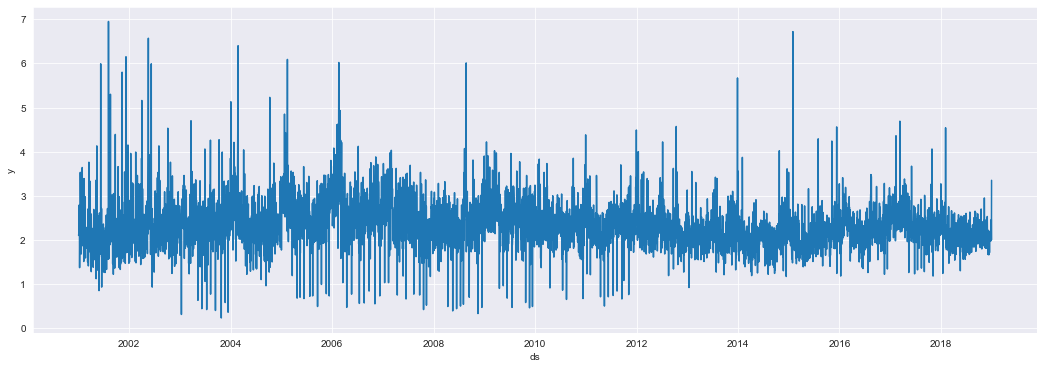

In [127]:
fig, ax = plt.subplots(figsize=(18,6))
sns.lineplot(x='ds', y='y', data=df_4out)

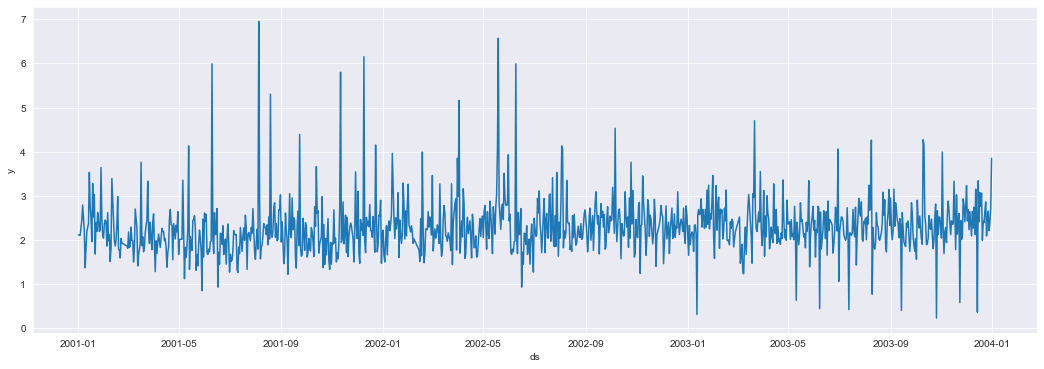

In [128]:
fig, ax = plt.subplots(figsize=(18,6))
sns.lineplot(x='ds', y='y', data=df_4out.loc[(df_4out['ds'] >= '01-01-2001') &
                                            (df_4out['ds'] <= '31-12-2003')])

### Modelo 4a - 24:00:00 - 29:59:00 (MADRUGADA)

### Teste do Modelo 4a
- correção manual dos outliers (puxei os mesmos valores de 2001, respeitando as variaçãoes de dia de semana)

In [129]:
#fit the model_04a
m4a = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, holidays=holidays)
m4a.add_country_holidays(country_name='BR')
m4a.fit(df_4out)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [130]:
future4a = m4a.make_future_dataframe(periods=244)
future4a.tail()

ds
6725 2019-08-28
6726 2019-08-29
6727 2019-08-30
6728 2019-08-31
6729 2019-09-01

In [131]:
forecast4a = m4a.predict(future4a)
forecast4a[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds  yhat  yhat_lower  yhat_upper
6725 2019-08-28  2.16        1.27        3.10
6726 2019-08-29  2.18        1.25        3.15
6727 2019-08-30  2.41        1.45        3.29
6728 2019-08-31  2.55        1.57        3.41
6729 2019-09-01  2.19        1.26        3.17

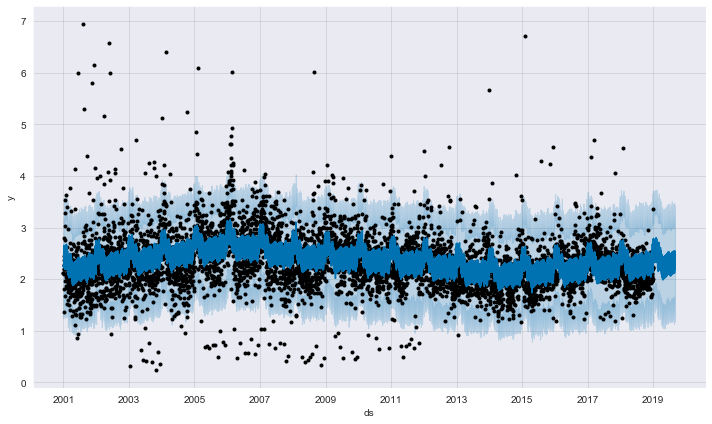

In [132]:
fig1_4a = m4a.plot(forecast4a)

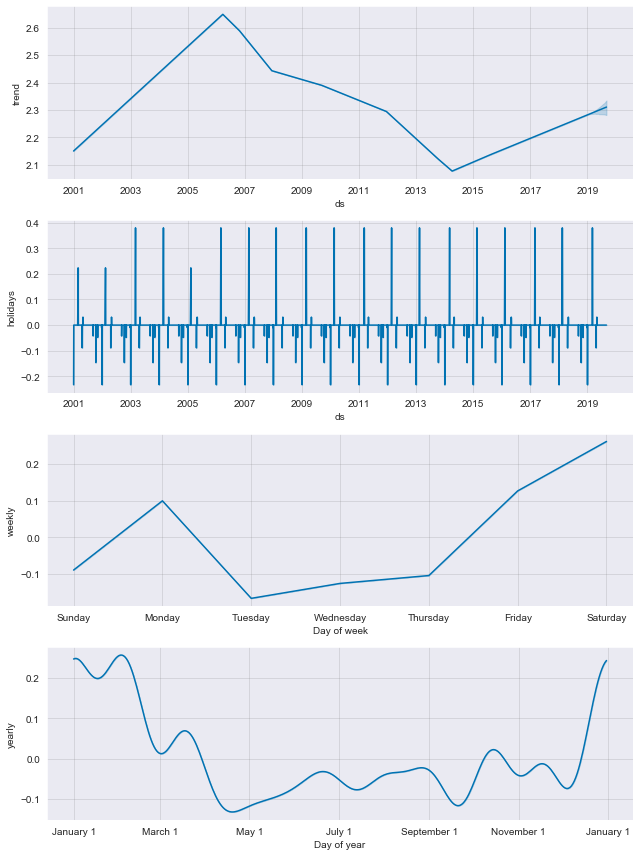

In [133]:
fig2_4a = m4a.plot_components(forecast4a)

In [134]:
model_4a = forecast4a[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [135]:
df_error_4a = model_4a.loc[(model_4a['ds'] >= '2019-01-01')]

In [136]:
df_error_4a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 6486 to 6729
Data columns (total 4 columns):
ds            244 non-null datetime64[ns]
yhat          244 non-null float64
yhat_lower    244 non-null float64
yhat_upper    244 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 9.5 KB


In [137]:
df_val_4a = pd.merge(df_error_4a, df_4_2019, on='ds')

In [138]:
df_val_4a

ds  yhat  yhat_lower  yhat_upper    y
0  2019-07-01  2.35        1.47        3.26 2.07
1  2019-07-02  2.08        1.18        3.04 1.92
2  2019-07-03  2.12        1.18        3.12 1.99
3  2019-07-04  2.14        1.26        3.07 1.80
4  2019-07-05  2.37        1.39        3.31 1.89
5  2019-07-06  2.50        1.55        3.39 1.92
6  2019-07-07  2.15        1.30        3.05 2.28
7  2019-07-08  2.33        1.40        3.22 2.41
8  2019-07-09  2.07        1.16        3.00 1.91
9  2019-07-10  2.10        1.20        3.04 2.04
10 2019-07-11  2.12        1.17        3.05 1.95
11 2019-07-12  2.35        1.47        3.25 1.70
12 2019-07-13  2.49        1.55        3.38 2.09
13 2019-07-14  2.14        1.20        2.95 2.38
14 2019-07-15  2.33        1.41        3.29 2.50
15 2019-07-16  2.06        1.18        3.02 1.58
16 2019-07-17  2.10        1.18        3.07 2.41
17 2019-07-18  2.13        1.22        3.07 2.01
18 2019-07-19  2.36        1.46        3.31 2.16
19 2019-07-20  2.50        1.62        3.45 2.29
20 2019-07-21  2.15        1.21        3.12 2.57
21 2019-07-22  2.34        1.46        3.27 2.27
22 2019-07-23  2.08        1.25        3.04 1.87
23 2019-07-24  2.12        1.19        3.07 2.10
24 2019-07-25  2.14        1.22        3.04 2.12
25 2019-07-26  2.38        1.42        3.28 2.06
26 2019-07-27  2.52        1.60        3.51 1.98
27 2019-07-28  2.17        1.28        2.98 2.48
28 2019-07-29  2.36        1.50        3.32 2.23
29 2019-07-30  2.09        1.17        3.00 2.07
30 2019-07-31  2.14        1.21        3.16 2.39
31 2019-08-01  2.16        1.23        3.11 1.84
32 2019-08-02  2.39        1.46        3.38 1.73
33 2019-08-03  2.53        1.64        3.45 2.25
34 2019-08-04  2.18        1.22        3.15 2.28
35 2019-08-05  2.37        1.43        3.34 2.32
36 2019-08-06  2.10        1.19        3.01 1.92
37 2019-08-07  2.15        1.25        3.04 1.90
38 2019-08-08  2.17        1.19        3.14 1.97
39 2019-08-09  2.40        1.44        3.32 2.10
40 2019-08-10  2.54        1.64        3.45 2.21
41 2019-08-11  2.18        1.23        3.15 2.16
42 2019-08-12  2.37        1.44        3.28 2.01
43 2019-08-13  2.11        1.24        3.06 1.79
44 2019-08-14  2.15        1.22        3.09 2.04
45 2019-08-15  2.17        1.27        3.09 1.87
46 2019-08-16  2.40        1.45        3.28 2.13
47 2019-08-17  2.54        1.55        3.44 2.07
48 2019-08-18  2.19        1.26        3.14 2.06
49 2019-08-19  2.38        1.54        3.27 1.82
50 2019-08-20  2.11        1.13        3.00 1.73
51 2019-08-21  2.16        1.29        3.13 1.89
52 2019-08-22  2.18        1.24        3.09 2.06
53 2019-08-23  2.41        1.45        3.37 2.17
54 2019-08-24  2.55        1.66        3.47 2.28
55 2019-08-25  2.20        1.26        3.13 2.39
56 2019-08-26  2.39        1.47        3.29 2.27
57 2019-08-27  2.12        1.18        2.97 1.90
58 2019-08-28  2.16        1.27        3.10 2.00
59 2019-08-29  2.18        1.25        3.15 2.04
60 2019-08-30  2.41        1.45        3.29 2.18
61 2019-08-31  2.55        1.57        3.41 2.08
62 2019-09-01  2.19        1.26        3.17 1.90
63 2019-09-01  2.19        1.26        3.17 1.90

In [139]:
df_val_4a['erro'] = df_val_4a['y'] - df_val_4a['yhat']

In [140]:
df_val_4a.describe()

yhat  yhat_lower  yhat_upper     y  erro
count 64.00       64.00       64.00 64.00 64.00
mean   2.26        1.34        3.19  2.07 -0.19
std    0.15        0.15        0.15  0.21  0.23
min    2.06        1.13        2.95  1.58 -0.66
25%    2.14        1.22        3.06  1.91 -0.32
50%    2.18        1.26        3.15  2.06 -0.20
75%    2.38        1.46        3.30  2.23 -0.07
max    2.55        1.66        3.51  2.57  0.42

Distribuição dos erros na validação com os dados reais de 2019


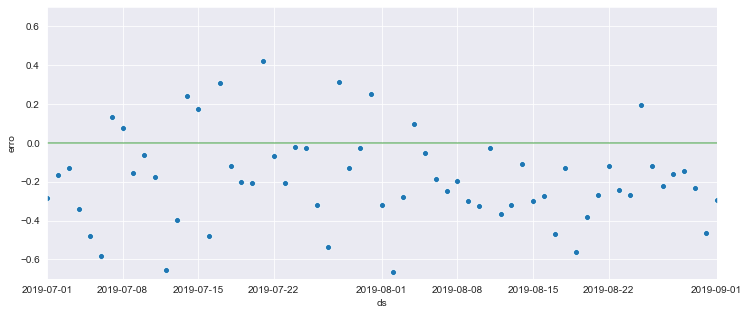

In [300]:
print('Distribuição dos erros na validação com os dados reais de 2019')
fig, ax = plt.subplots(figsize=(12,5))
#plt.xlim('2019','2020')
sns.lineplot(x = 'ds', y = 0, data=df_val_4a, color='green', alpha = 0.5)
sns.scatterplot(x='ds', y='erro', data=df_val_4a)
ax.set_xlim(pd.Timestamp('2019-07-01'), pd.Timestamp('2019-09-01'))
ax.set_ylim(-0.7, 0.7);

In [142]:
df_val_4a['month'] = df_val_4a['ds'].dt.month

In [143]:
df_val_4a.tail()

ds  yhat  yhat_lower  yhat_upper    y  erro  month
59 2019-08-29  2.18        1.25        3.15 2.04 -0.14      8
60 2019-08-30  2.41        1.45        3.29 2.18 -0.23      8
61 2019-08-31  2.55        1.57        3.41 2.08 -0.47      8
62 2019-09-01  2.19        1.26        3.17 1.90 -0.29      9
63 2019-09-01  2.19        1.26        3.17 1.90 -0.29      9

Distribuição dos erros na validação com os dados reais de 2019 - MÊS


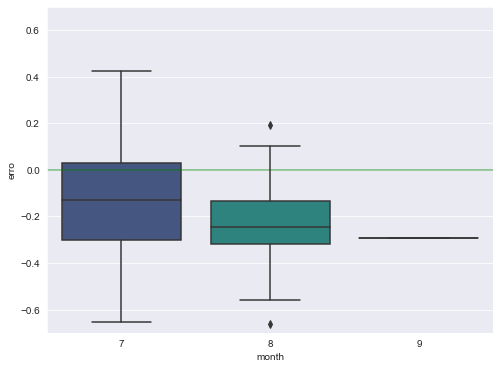

In [302]:
print('Distribuição dos erros na validação com os dados reais de 2019 - MÊS')
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(x = [*range(-1,10)], y = 0, color='green', alpha = 0.5)
ax.set_ylim(-0.7, 0.7);
sns.boxplot(x='month', y='erro', data=df_val_4a, palette='viridis');

Comparação Real - azul | Previsto - vermelho


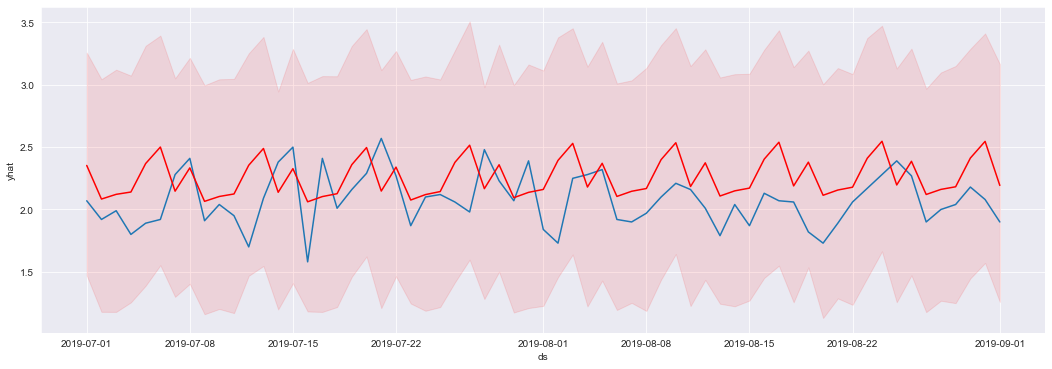

In [145]:
print('Comparação Real - azul | Previsto - vermelho')
fig, ax = plt.subplots(figsize=(18,6))
sns.lineplot(x='ds', y='y', data=df_val_4a)
sns.lineplot(x='ds', y='yhat', data=df_val_4a, color='red', ci=95, err_style='band', ax=ax)
ax.fill_between(df_val_4a['ds'],df_val_4a['yhat_upper'], df_val_4a['yhat_lower'], alpha=0.1, color='red');